# Classification and Regression with a Neural Network in Pytorch

Welcome to your first programming assignment! 
In this assignment you will build your first classification and regression neural networks.
This assignment is a 'step-through' guide to implement a simple fully-connected neural network in Pytorch.

* In the first part of this exercise, you will implement a neural network with a 2 dimensional input. Your dataset is based on a two <a href=https://en.wikipedia.org/wiki/Crescent> crescent </a> moon-shaped groups for classification.

* Then, in the second part of this exercise, you will implement a regression model for predicting the output of a two dimensional function.

# Packages
Let's first import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [1]:
import datargs
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import attr
import seaborn as sns

# Dataset

In [2]:
id_num_str = input("Please Enter your Israeli ID?")
if (len(id_num_str) != 9):
    print('ID should contain 9 digits')
if (id_num_str.isdigit() is False):
    print('ID should contain only digits')
id_num = list(id_num_str[-3:])
random_num = sum(list(map(int, id_num)))

Please Enter your Israeli ID?205783277


In [4]:
np.random.seed(random_num)
torch.manual_seed(random_num)
x, y = make_moons(500, noise=0.2, random_state=random_num)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=random_num)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=random_num)

**Visualize the dataset using matplotlib:**

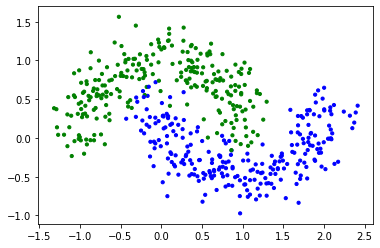

In [5]:
### START CODE HERE ###
colormap = np.array(['g', 'b'])
plt.scatter(x[:, 0], x[:, 1], s=10, c=colormap[y])

# Simple Logistic Regression

What you are required to do:

1. Implement a 2-class classification neural network with a zero hidden layer.
2. Plot loss vs epoch.
3. Plot AUC vs epoch for train and test sets. 
4. Plot ROC curve and calculate AUC for the test set.
5. Plot the learned decision boundary.
6. Briefly interpret graph's results.   

How you will do it:

1. Prepare the Data.
2. Define the Model.
3. Train the Model.
4. Evaluate the Model.
5. Visualization.

**Prepare the data:**

In [6]:
"""Args for the assigment"""

# NN architecture args
num_net_channels_part_a = [2, 1]
num_net_channels_part_b = [2, 16, 1]
num_net_channels_part_c_1 = [2, 128, 64, 32, 1]
num_net_channels_part_c_2 = [2, 512, 256, 128, 64, 32, 1]
# NN training args
tr_batch_size = 50
val_test_batch_size = 50
num_epochs = 2000
lr = 1e-2

**Help function for the Nerual Network:**
1. EarlyStopping
2. TabularDataset

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
class TabularDataset(torch.utils.data.Dataset):
    
    def __init__(self, features, labels):
        'Initialization'
        self.features = torch.Tensor(features).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.features)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.features[index, :]

        # Load data and get label
        y = self.labels[index]

        return X, y

**Define the Model:**
With this model we gonna use in all parts  

In [9]:
class MlpNetwork(nn.Module):
    """Our neural network
    in_features: the number of input features
    num_features: the number of features used in intermmidiate layers
    """

    def __init__(self, num_features, activation_func, classifier=False):
        super(MlpNetwork, self).__init__()
        model_layers = [(nn.Linear(num_features[0], num_features[1]))]
        for i in range(2, len(num_features)):
            model_layers.append(activation_func)
            model_layers.append(nn.Linear(num_features[i-1], num_features[i]))
        if classifier:
            model_layers.append(activation_func)
        self.fc_module = nn.Sequential(*model_layers)

    def forward(self, x):
        x = self.fc_module(x)
        return torch.flatten(x)

**Utils function for the nerual network:**
1. create_generators
2. infer
3. test_accuracy

In [10]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test):
    train_set = TabularDataset(x_train, y_train)
    val_set = TabularDataset(x_val, y_val)
    test_set = TabularDataset(x_test, y_test)

    training_generator = DataLoader(train_set, x_train.shape[0])
    validation_generator = DataLoader(val_set, x_val.shape[0])
    test_generator = DataLoader(test_set, x_test.shape[0])
    return training_generator, validation_generator, test_generator

In [11]:
def infer(net, dataloader, criterion_func=nn.BCELoss):
    """
    check the network before training
    """
    criterion = criterion_func()
    net.eval()
    running_loss = 0
    for x, y in dataloader:
        with torch.no_grad():
            pred = net(x)
            loss = criterion(pred, y)
        running_loss += loss
    return round((running_loss / len(dataloader)).item(), 4)

In [12]:
def test_accuracy(net, x_test, y_test):
    y_pred_p = net(torch.from_numpy(x_test).to(torch.float32))
    y_pred_p = y_pred_p.detach().numpy()
    y_pred = np.where(y_pred_p > 0.5, 1, 0).flatten()
    print(round(sum(y_test == y_pred) / y_test.shape[0], 2))
    return y_pred_p

**Training and validation:**

In [13]:
### START CODE HERE ###
def train(net, training_generator, validation_generator, verbose=False, opt_func=torch.optim.Adam,
          criterion_func=nn.BCELoss, epochs=100, batch_size=10, lr=0.01,check_early_stopping=False, check_auc_roc=False):
    """
    train the model
    """
    
    opt = opt_func(net.parameters(), lr=lr)
    criterion = criterion_func()
    early_stopping = EarlyStopping(patience=30, verbose=False, delta=1e-5)
    
    counter = 0
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    roc_auc_per_train = []
    roc_auc_per_val = []
    for e in range(epochs):
        net.train()
        train_losses = []
        roc_auc_list = []
        for inputs, targets in training_generator:
            counter += 1
            # zero accumulated gradients
            opt.zero_grad()
            # Forward
            output= net(inputs)
            if check_auc_roc:
                false_positive_rate, recall, thresholds = roc_curve(targets.detach().numpy(), output.detach().numpy())
                roc_auc = auc(false_positive_rate, recall)
                roc_auc_list.append(roc_auc)
            # calculate the loss and perform backprop
            loss = criterion(output, targets)
            train_losses.append(loss.item())
            loss.backward()
            opt.step()
        
        train_losses_per_epoch.append(np.mean(train_losses))
        if check_auc_roc:
            roc_auc_per_train.append(np.mean(roc_auc_list))    

        val_losses = [] 
        roc_auc_val = []
        net.eval()
        for inputs, targets in validation_generator:
            with torch.no_grad():
                output= net(inputs)
                val_loss = criterion(output, targets)
            if check_auc_roc:
                false_positive_rate, recall, thresholds = roc_curve(targets.detach().numpy(), output.detach().numpy())
                roc_auc = auc(false_positive_rate, recall)
                roc_auc_val.append(roc_auc)
            val_losses.append(val_loss.item())

        val_losses_per_epoch.append(np.mean(val_losses))
        if check_auc_roc:
            roc_auc_per_val.append(np.mean(roc_auc_val))
        
        early_stopping(np.average(val_losses), net)
        if early_stopping.early_stop and check_early_stopping:
            print("Early stopping")
            break
        if verbose:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.5f}...".format(loss.item()),
                  "Val Loss: {:.5f}".format(np.mean(val_losses)))
        
    if check_auc_roc:
        return train_losses_per_epoch, val_losses_per_epoch, roc_auc_per_train, roc_auc_per_val
    return train_losses_per_epoch, val_losses_per_epoch    

**Visualize function:**
1. Loss of train and validation vs epochs
2. Auc of train and validation vs epochs
3. Roc cruve
4. Decision boundary

In [14]:
def plot_loss_vs_epochs(train_losess, val_losses):
    epochs_list = list(range(1, len(train_losess) + 1))
    plt.plot(epochs_list, train_losess, label="Train loss")
    plt.plot(epochs_list, val_losses, label="Val loss")
    plt.ylim(ymin=0)
    plt.legend()

In [15]:
def plot_auc_vs_epochs(roc_auc_train, roc_auc_val):
    epochs_list = list(range(1, len(roc_auc_train) + 1))
    plt.plot(epochs_list, roc_auc_train, label="Train")
    plt.plot(epochs_list, roc_auc_val, label="Validation")
    plt.legend()

In [16]:
def plot_roc_cruve(y_test, y_pred_p):
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred_p)
    roc_auc = auc(false_positive_rate, recall)
    print("The test auc is:", round(roc_auc, 2))
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.show()

In [17]:
def plot_decision_boundary(X, X_test, Y_test, net):    
    X_test_t = torch.FloatTensor(X_test)
    y_hat_test = net(X_test_t)
    y_hat_test_class = np.where(y_hat_test.detach().numpy() > 0.5, 1, 0)
    test_accuracy = np.sum(Y_test.flatten()==y_hat_test_class) / len(Y_test)
    print("Test Accuracy {:.2f}".format(test_accuracy))

    # Plot the decision boundary
    # Determine grid range in x and y directions
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

    # Set grid spacing parameter
    spacing = min(x_max - x_min, y_max - y_min) / 100

    # Create grid
    XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                   np.arange(y_min, y_max, spacing))

    # Concatenate data to match input
    data = np.hstack((XX.ravel().reshape(-1,1), 
                      YY.ravel().reshape(-1,1)))

    # Pass data to predict method
    data_t = torch.FloatTensor(data)
    db_prob = net(data_t)

    clf = np.where(db_prob<0.5,0,1)

    Z = clf.reshape(XX.shape)

    plt.figure(figsize=(12,8))
    plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
    plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, 
                cmap=plt.cm.Accent)
    plt.show()

**Result for Simple Logistic Regression:**

In [18]:
training_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test,y_test)
net = MlpNetwork(num_net_channels_part_a, nn.Sigmoid(), classifier=True)
opt = torch.optim.Adam
criterion = nn.BCELoss

In [19]:
print("Loss before train on the Test set:")
print(infer(net, test_generator))
print("Accuracy before train:")
_ = test_accuracy(net, x_test, y_test)

Loss before train on the Test set:
0.8874
Accuracy before train:
0.21


#### Without Earlystopping

In [20]:
train_losess, val_losses, roc_auc_train, roc_auc_val = train(net, training_generator, validation_generator, verbose=True,
                                                             opt_func=opt, criterion_func=criterion, epochs=num_epochs,
                                                             lr=0.01, check_early_stopping=False, check_auc_roc=True)

Epoch: 1/2000... Step: 1... Loss: 0.90161... Val Loss: 0.84911
Epoch: 2/2000... Step: 2... Loss: 0.89490... Val Loss: 0.84348
Epoch: 3/2000... Step: 3... Loss: 0.88824... Val Loss: 0.83788
Epoch: 4/2000... Step: 4... Loss: 0.88163... Val Loss: 0.83233
Epoch: 5/2000... Step: 5... Loss: 0.87507... Val Loss: 0.82681
Epoch: 6/2000... Step: 6... Loss: 0.86855... Val Loss: 0.82134
Epoch: 7/2000... Step: 7... Loss: 0.86209... Val Loss: 0.81590
Epoch: 8/2000... Step: 8... Loss: 0.85567... Val Loss: 0.81050
Epoch: 9/2000... Step: 9... Loss: 0.84931... Val Loss: 0.80515
Epoch: 10/2000... Step: 10... Loss: 0.84299... Val Loss: 0.79984
Epoch: 11/2000... Step: 11... Loss: 0.83674... Val Loss: 0.79457
Epoch: 12/2000... Step: 12... Loss: 0.83053... Val Loss: 0.78934
Epoch: 13/2000... Step: 13... Loss: 0.82438... Val Loss: 0.78416
Epoch: 14/2000... Step: 14... Loss: 0.81829... Val Loss: 0.77902
Epoch: 15/2000... Step: 15... Loss: 0.81225... Val Loss: 0.77393
Epoch: 16/2000... Step: 16... Loss: 0.80627

Epoch: 135/2000... Step: 135... Loss: 0.43657... Val Loss: 0.43164
Epoch: 136/2000... Step: 136... Loss: 0.43525... Val Loss: 0.43035
Epoch: 137/2000... Step: 137... Loss: 0.43395... Val Loss: 0.42908
Epoch: 138/2000... Step: 138... Loss: 0.43266... Val Loss: 0.42783
Epoch: 139/2000... Step: 139... Loss: 0.43139... Val Loss: 0.42659
Epoch: 140/2000... Step: 140... Loss: 0.43013... Val Loss: 0.42536
Epoch: 141/2000... Step: 141... Loss: 0.42889... Val Loss: 0.42415
Epoch: 142/2000... Step: 142... Loss: 0.42766... Val Loss: 0.42295
Epoch: 143/2000... Step: 143... Loss: 0.42644... Val Loss: 0.42177
Epoch: 144/2000... Step: 144... Loss: 0.42524... Val Loss: 0.42060
Epoch: 145/2000... Step: 145... Loss: 0.42405... Val Loss: 0.41944
Epoch: 146/2000... Step: 146... Loss: 0.42287... Val Loss: 0.41830
Epoch: 147/2000... Step: 147... Loss: 0.42171... Val Loss: 0.41717
Epoch: 148/2000... Step: 148... Loss: 0.42056... Val Loss: 0.41605
Epoch: 149/2000... Step: 149... Loss: 0.41942... Val Loss: 0.4

Epoch: 277/2000... Step: 277... Loss: 0.33609... Val Loss: 0.33362
Epoch: 278/2000... Step: 278... Loss: 0.33571... Val Loss: 0.33326
Epoch: 279/2000... Step: 279... Loss: 0.33534... Val Loss: 0.33289
Epoch: 280/2000... Step: 280... Loss: 0.33497... Val Loss: 0.33253
Epoch: 281/2000... Step: 281... Loss: 0.33461... Val Loss: 0.33217
Epoch: 282/2000... Step: 282... Loss: 0.33424... Val Loss: 0.33181
Epoch: 283/2000... Step: 283... Loss: 0.33388... Val Loss: 0.33145
Epoch: 284/2000... Step: 284... Loss: 0.33352... Val Loss: 0.33110
Epoch: 285/2000... Step: 285... Loss: 0.33317... Val Loss: 0.33075
Epoch: 286/2000... Step: 286... Loss: 0.33281... Val Loss: 0.33040
Epoch: 287/2000... Step: 287... Loss: 0.33246... Val Loss: 0.33005
Epoch: 288/2000... Step: 288... Loss: 0.33211... Val Loss: 0.32970
Epoch: 289/2000... Step: 289... Loss: 0.33176... Val Loss: 0.32936
Epoch: 290/2000... Step: 290... Loss: 0.33142... Val Loss: 0.32902
Epoch: 291/2000... Step: 291... Loss: 0.33107... Val Loss: 0.3

Epoch: 399/2000... Step: 399... Loss: 0.30313... Val Loss: 0.30053
Epoch: 400/2000... Step: 400... Loss: 0.30293... Val Loss: 0.30033
Epoch: 401/2000... Step: 401... Loss: 0.30273... Val Loss: 0.30013
Epoch: 402/2000... Step: 402... Loss: 0.30254... Val Loss: 0.29993
Epoch: 403/2000... Step: 403... Loss: 0.30235... Val Loss: 0.29973
Epoch: 404/2000... Step: 404... Loss: 0.30215... Val Loss: 0.29953
Epoch: 405/2000... Step: 405... Loss: 0.30196... Val Loss: 0.29933
Epoch: 406/2000... Step: 406... Loss: 0.30177... Val Loss: 0.29913
Epoch: 407/2000... Step: 407... Loss: 0.30158... Val Loss: 0.29893
Epoch: 408/2000... Step: 408... Loss: 0.30139... Val Loss: 0.29873
Epoch: 409/2000... Step: 409... Loss: 0.30120... Val Loss: 0.29854
Epoch: 410/2000... Step: 410... Loss: 0.30101... Val Loss: 0.29834
Epoch: 411/2000... Step: 411... Loss: 0.30083... Val Loss: 0.29815
Epoch: 412/2000... Step: 412... Loss: 0.30064... Val Loss: 0.29795
Epoch: 413/2000... Step: 413... Loss: 0.30045... Val Loss: 0.2

Epoch: 528/2000... Step: 528... Loss: 0.28334... Val Loss: 0.27940
Epoch: 529/2000... Step: 529... Loss: 0.28322... Val Loss: 0.27927
Epoch: 530/2000... Step: 530... Loss: 0.28311... Val Loss: 0.27913
Epoch: 531/2000... Step: 531... Loss: 0.28299... Val Loss: 0.27900
Epoch: 532/2000... Step: 532... Loss: 0.28287... Val Loss: 0.27887
Epoch: 533/2000... Step: 533... Loss: 0.28275... Val Loss: 0.27874
Epoch: 534/2000... Step: 534... Loss: 0.28264... Val Loss: 0.27861
Epoch: 535/2000... Step: 535... Loss: 0.28252... Val Loss: 0.27848
Epoch: 536/2000... Step: 536... Loss: 0.28241... Val Loss: 0.27835
Epoch: 537/2000... Step: 537... Loss: 0.28229... Val Loss: 0.27822
Epoch: 538/2000... Step: 538... Loss: 0.28218... Val Loss: 0.27809
Epoch: 539/2000... Step: 539... Loss: 0.28206... Val Loss: 0.27797
Epoch: 540/2000... Step: 540... Loss: 0.28195... Val Loss: 0.27784
Epoch: 541/2000... Step: 541... Loss: 0.28183... Val Loss: 0.27771
Epoch: 542/2000... Step: 542... Loss: 0.28172... Val Loss: 0.2

Epoch: 662/2000... Step: 662... Loss: 0.27062... Val Loss: 0.26469
Epoch: 663/2000... Step: 663... Loss: 0.27054... Val Loss: 0.26460
Epoch: 664/2000... Step: 664... Loss: 0.27047... Val Loss: 0.26451
Epoch: 665/2000... Step: 665... Loss: 0.27039... Val Loss: 0.26442
Epoch: 666/2000... Step: 666... Loss: 0.27032... Val Loss: 0.26434
Epoch: 667/2000... Step: 667... Loss: 0.27025... Val Loss: 0.26425
Epoch: 668/2000... Step: 668... Loss: 0.27017... Val Loss: 0.26416
Epoch: 669/2000... Step: 669... Loss: 0.27010... Val Loss: 0.26407
Epoch: 670/2000... Step: 670... Loss: 0.27003... Val Loss: 0.26398
Epoch: 671/2000... Step: 671... Loss: 0.26995... Val Loss: 0.26389
Epoch: 672/2000... Step: 672... Loss: 0.26988... Val Loss: 0.26380
Epoch: 673/2000... Step: 673... Loss: 0.26981... Val Loss: 0.26372
Epoch: 674/2000... Step: 674... Loss: 0.26974... Val Loss: 0.26363
Epoch: 675/2000... Step: 675... Loss: 0.26966... Val Loss: 0.26354
Epoch: 676/2000... Step: 676... Loss: 0.26959... Val Loss: 0.2

Epoch: 795/2000... Step: 795... Loss: 0.26256... Val Loss: 0.25464
Epoch: 796/2000... Step: 796... Loss: 0.26251... Val Loss: 0.25457
Epoch: 797/2000... Step: 797... Loss: 0.26246... Val Loss: 0.25451
Epoch: 798/2000... Step: 798... Loss: 0.26242... Val Loss: 0.25445
Epoch: 799/2000... Step: 799... Loss: 0.26237... Val Loss: 0.25439
Epoch: 800/2000... Step: 800... Loss: 0.26232... Val Loss: 0.25432
Epoch: 801/2000... Step: 801... Loss: 0.26227... Val Loss: 0.25426
Epoch: 802/2000... Step: 802... Loss: 0.26223... Val Loss: 0.25420
Epoch: 803/2000... Step: 803... Loss: 0.26218... Val Loss: 0.25414
Epoch: 804/2000... Step: 804... Loss: 0.26213... Val Loss: 0.25408
Epoch: 805/2000... Step: 805... Loss: 0.26208... Val Loss: 0.25402
Epoch: 806/2000... Step: 806... Loss: 0.26204... Val Loss: 0.25396
Epoch: 807/2000... Step: 807... Loss: 0.26199... Val Loss: 0.25390
Epoch: 808/2000... Step: 808... Loss: 0.26194... Val Loss: 0.25383
Epoch: 809/2000... Step: 809... Loss: 0.26190... Val Loss: 0.2

Epoch: 919/2000... Step: 919... Loss: 0.25762... Val Loss: 0.24803
Epoch: 920/2000... Step: 920... Loss: 0.25759... Val Loss: 0.24798
Epoch: 921/2000... Step: 921... Loss: 0.25756... Val Loss: 0.24794
Epoch: 922/2000... Step: 922... Loss: 0.25752... Val Loss: 0.24789
Epoch: 923/2000... Step: 923... Loss: 0.25749... Val Loss: 0.24785
Epoch: 924/2000... Step: 924... Loss: 0.25746... Val Loss: 0.24780
Epoch: 925/2000... Step: 925... Loss: 0.25743... Val Loss: 0.24776
Epoch: 926/2000... Step: 926... Loss: 0.25740... Val Loss: 0.24772
Epoch: 927/2000... Step: 927... Loss: 0.25736... Val Loss: 0.24767
Epoch: 928/2000... Step: 928... Loss: 0.25733... Val Loss: 0.24763
Epoch: 929/2000... Step: 929... Loss: 0.25730... Val Loss: 0.24758
Epoch: 930/2000... Step: 930... Loss: 0.25727... Val Loss: 0.24754
Epoch: 931/2000... Step: 931... Loss: 0.25724... Val Loss: 0.24750
Epoch: 932/2000... Step: 932... Loss: 0.25721... Val Loss: 0.24745
Epoch: 933/2000... Step: 933... Loss: 0.25718... Val Loss: 0.2

Epoch: 1041/2000... Step: 1041... Loss: 0.25434... Val Loss: 0.24334
Epoch: 1042/2000... Step: 1042... Loss: 0.25432... Val Loss: 0.24331
Epoch: 1043/2000... Step: 1043... Loss: 0.25429... Val Loss: 0.24328
Epoch: 1044/2000... Step: 1044... Loss: 0.25427... Val Loss: 0.24325
Epoch: 1045/2000... Step: 1045... Loss: 0.25425... Val Loss: 0.24321
Epoch: 1046/2000... Step: 1046... Loss: 0.25423... Val Loss: 0.24318
Epoch: 1047/2000... Step: 1047... Loss: 0.25421... Val Loss: 0.24315
Epoch: 1048/2000... Step: 1048... Loss: 0.25419... Val Loss: 0.24312
Epoch: 1049/2000... Step: 1049... Loss: 0.25416... Val Loss: 0.24309
Epoch: 1050/2000... Step: 1050... Loss: 0.25414... Val Loss: 0.24305
Epoch: 1051/2000... Step: 1051... Loss: 0.25412... Val Loss: 0.24302
Epoch: 1052/2000... Step: 1052... Loss: 0.25410... Val Loss: 0.24299
Epoch: 1053/2000... Step: 1053... Loss: 0.25408... Val Loss: 0.24296
Epoch: 1054/2000... Step: 1054... Loss: 0.25406... Val Loss: 0.24293
Epoch: 1055/2000... Step: 1055... 

Epoch: 1166/2000... Step: 1166... Loss: 0.25206... Val Loss: 0.23986
Epoch: 1167/2000... Step: 1167... Loss: 0.25205... Val Loss: 0.23984
Epoch: 1168/2000... Step: 1168... Loss: 0.25203... Val Loss: 0.23982
Epoch: 1169/2000... Step: 1169... Loss: 0.25202... Val Loss: 0.23979
Epoch: 1170/2000... Step: 1170... Loss: 0.25200... Val Loss: 0.23977
Epoch: 1171/2000... Step: 1171... Loss: 0.25199... Val Loss: 0.23975
Epoch: 1172/2000... Step: 1172... Loss: 0.25197... Val Loss: 0.23972
Epoch: 1173/2000... Step: 1173... Loss: 0.25196... Val Loss: 0.23970
Epoch: 1174/2000... Step: 1174... Loss: 0.25195... Val Loss: 0.23968
Epoch: 1175/2000... Step: 1175... Loss: 0.25193... Val Loss: 0.23965
Epoch: 1176/2000... Step: 1176... Loss: 0.25192... Val Loss: 0.23963
Epoch: 1177/2000... Step: 1177... Loss: 0.25190... Val Loss: 0.23961
Epoch: 1178/2000... Step: 1178... Loss: 0.25189... Val Loss: 0.23959
Epoch: 1179/2000... Step: 1179... Loss: 0.25187... Val Loss: 0.23956
Epoch: 1180/2000... Step: 1180... 

Epoch: 1290/2000... Step: 1290... Loss: 0.25054... Val Loss: 0.23735
Epoch: 1291/2000... Step: 1291... Loss: 0.25053... Val Loss: 0.23733
Epoch: 1292/2000... Step: 1292... Loss: 0.25052... Val Loss: 0.23732
Epoch: 1293/2000... Step: 1293... Loss: 0.25051... Val Loss: 0.23730
Epoch: 1294/2000... Step: 1294... Loss: 0.25050... Val Loss: 0.23728
Epoch: 1295/2000... Step: 1295... Loss: 0.25049... Val Loss: 0.23726
Epoch: 1296/2000... Step: 1296... Loss: 0.25048... Val Loss: 0.23725
Epoch: 1297/2000... Step: 1297... Loss: 0.25047... Val Loss: 0.23723
Epoch: 1298/2000... Step: 1298... Loss: 0.25046... Val Loss: 0.23721
Epoch: 1299/2000... Step: 1299... Loss: 0.25045... Val Loss: 0.23720
Epoch: 1300/2000... Step: 1300... Loss: 0.25044... Val Loss: 0.23718
Epoch: 1301/2000... Step: 1301... Loss: 0.25043... Val Loss: 0.23716
Epoch: 1302/2000... Step: 1302... Loss: 0.25042... Val Loss: 0.23715
Epoch: 1303/2000... Step: 1303... Loss: 0.25041... Val Loss: 0.23713
Epoch: 1304/2000... Step: 1304... 

Epoch: 1410/2000... Step: 1410... Loss: 0.24954... Val Loss: 0.23555
Epoch: 1411/2000... Step: 1411... Loss: 0.24954... Val Loss: 0.23554
Epoch: 1412/2000... Step: 1412... Loss: 0.24953... Val Loss: 0.23553
Epoch: 1413/2000... Step: 1413... Loss: 0.24952... Val Loss: 0.23551
Epoch: 1414/2000... Step: 1414... Loss: 0.24952... Val Loss: 0.23550
Epoch: 1415/2000... Step: 1415... Loss: 0.24951... Val Loss: 0.23549
Epoch: 1416/2000... Step: 1416... Loss: 0.24950... Val Loss: 0.23547
Epoch: 1417/2000... Step: 1417... Loss: 0.24950... Val Loss: 0.23546
Epoch: 1418/2000... Step: 1418... Loss: 0.24949... Val Loss: 0.23545
Epoch: 1419/2000... Step: 1419... Loss: 0.24948... Val Loss: 0.23544
Epoch: 1420/2000... Step: 1420... Loss: 0.24948... Val Loss: 0.23542
Epoch: 1421/2000... Step: 1421... Loss: 0.24947... Val Loss: 0.23541
Epoch: 1422/2000... Step: 1422... Loss: 0.24946... Val Loss: 0.23540
Epoch: 1423/2000... Step: 1423... Loss: 0.24946... Val Loss: 0.23539
Epoch: 1424/2000... Step: 1424... 

Epoch: 1545/2000... Step: 1545... Loss: 0.24880... Val Loss: 0.23407
EarlyStopping counter: 1 out of 30
Epoch: 1546/2000... Step: 1546... Loss: 0.24880... Val Loss: 0.23406
Epoch: 1547/2000... Step: 1547... Loss: 0.24880... Val Loss: 0.23405
EarlyStopping counter: 1 out of 30
Epoch: 1548/2000... Step: 1548... Loss: 0.24879... Val Loss: 0.23404
Epoch: 1549/2000... Step: 1549... Loss: 0.24879... Val Loss: 0.23403
EarlyStopping counter: 1 out of 30
Epoch: 1550/2000... Step: 1550... Loss: 0.24878... Val Loss: 0.23402
Epoch: 1551/2000... Step: 1551... Loss: 0.24878... Val Loss: 0.23401
EarlyStopping counter: 1 out of 30
Epoch: 1552/2000... Step: 1552... Loss: 0.24877... Val Loss: 0.23400
Epoch: 1553/2000... Step: 1553... Loss: 0.24877... Val Loss: 0.23399
EarlyStopping counter: 1 out of 30
Epoch: 1554/2000... Step: 1554... Loss: 0.24877... Val Loss: 0.23398
Epoch: 1555/2000... Step: 1555... Loss: 0.24876... Val Loss: 0.23397
EarlyStopping counter: 1 out of 30
Epoch: 1556/2000... Step: 1556.

EarlyStopping counter: 1 out of 30
Epoch: 1650/2000... Step: 1650... Loss: 0.24842... Val Loss: 0.23320
Epoch: 1651/2000... Step: 1651... Loss: 0.24842... Val Loss: 0.23319
EarlyStopping counter: 1 out of 30
Epoch: 1652/2000... Step: 1652... Loss: 0.24841... Val Loss: 0.23318
Epoch: 1653/2000... Step: 1653... Loss: 0.24841... Val Loss: 0.23318
EarlyStopping counter: 1 out of 30
Epoch: 1654/2000... Step: 1654... Loss: 0.24841... Val Loss: 0.23317
Epoch: 1655/2000... Step: 1655... Loss: 0.24841... Val Loss: 0.23316
EarlyStopping counter: 1 out of 30
Epoch: 1656/2000... Step: 1656... Loss: 0.24840... Val Loss: 0.23315
Epoch: 1657/2000... Step: 1657... Loss: 0.24840... Val Loss: 0.23315
EarlyStopping counter: 1 out of 30
Epoch: 1658/2000... Step: 1658... Loss: 0.24840... Val Loss: 0.23314
Epoch: 1659/2000... Step: 1659... Loss: 0.24839... Val Loss: 0.23313
EarlyStopping counter: 1 out of 30
Epoch: 1660/2000... Step: 1660... Loss: 0.24839... Val Loss: 0.23313
Epoch: 1661/2000... Step: 1661.

EarlyStopping counter: 1 out of 30
Epoch: 1760/2000... Step: 1760... Loss: 0.24814... Val Loss: 0.23249
Epoch: 1761/2000... Step: 1761... Loss: 0.24814... Val Loss: 0.23249
EarlyStopping counter: 1 out of 30
Epoch: 1762/2000... Step: 1762... Loss: 0.24814... Val Loss: 0.23248
Epoch: 1763/2000... Step: 1763... Loss: 0.24814... Val Loss: 0.23248
EarlyStopping counter: 1 out of 30
Epoch: 1764/2000... Step: 1764... Loss: 0.24814... Val Loss: 0.23247
Epoch: 1765/2000... Step: 1765... Loss: 0.24813... Val Loss: 0.23247
EarlyStopping counter: 1 out of 30
Epoch: 1766/2000... Step: 1766... Loss: 0.24813... Val Loss: 0.23246
Epoch: 1767/2000... Step: 1767... Loss: 0.24813... Val Loss: 0.23245
EarlyStopping counter: 1 out of 30
Epoch: 1768/2000... Step: 1768... Loss: 0.24813... Val Loss: 0.23245
Epoch: 1769/2000... Step: 1769... Loss: 0.24813... Val Loss: 0.23244
EarlyStopping counter: 1 out of 30
Epoch: 1770/2000... Step: 1770... Loss: 0.24812... Val Loss: 0.23244
Epoch: 1771/2000... Step: 1771.

Epoch: 1862/2000... Step: 1862... Loss: 0.24797... Val Loss: 0.23198
EarlyStopping counter: 1 out of 30
Epoch: 1863/2000... Step: 1863... Loss: 0.24797... Val Loss: 0.23198
EarlyStopping counter: 2 out of 30
Epoch: 1864/2000... Step: 1864... Loss: 0.24797... Val Loss: 0.23197
Epoch: 1865/2000... Step: 1865... Loss: 0.24797... Val Loss: 0.23197
EarlyStopping counter: 1 out of 30
Epoch: 1866/2000... Step: 1866... Loss: 0.24796... Val Loss: 0.23197
EarlyStopping counter: 2 out of 30
Epoch: 1867/2000... Step: 1867... Loss: 0.24796... Val Loss: 0.23196
Epoch: 1868/2000... Step: 1868... Loss: 0.24796... Val Loss: 0.23196
EarlyStopping counter: 1 out of 30
Epoch: 1869/2000... Step: 1869... Loss: 0.24796... Val Loss: 0.23195
EarlyStopping counter: 2 out of 30
Epoch: 1870/2000... Step: 1870... Loss: 0.24796... Val Loss: 0.23195
Epoch: 1871/2000... Step: 1871... Loss: 0.24796... Val Loss: 0.23194
EarlyStopping counter: 1 out of 30
Epoch: 1872/2000... Step: 1872... Loss: 0.24796... Val Loss: 0.23

Epoch: 1970/2000... Step: 1970... Loss: 0.24784... Val Loss: 0.23156
EarlyStopping counter: 1 out of 30
Epoch: 1971/2000... Step: 1971... Loss: 0.24784... Val Loss: 0.23156
EarlyStopping counter: 2 out of 30
Epoch: 1972/2000... Step: 1972... Loss: 0.24784... Val Loss: 0.23155
Epoch: 1973/2000... Step: 1973... Loss: 0.24784... Val Loss: 0.23155
EarlyStopping counter: 1 out of 30
Epoch: 1974/2000... Step: 1974... Loss: 0.24784... Val Loss: 0.23155
EarlyStopping counter: 2 out of 30
Epoch: 1975/2000... Step: 1975... Loss: 0.24784... Val Loss: 0.23154
Epoch: 1976/2000... Step: 1976... Loss: 0.24784... Val Loss: 0.23154
EarlyStopping counter: 1 out of 30
Epoch: 1977/2000... Step: 1977... Loss: 0.24784... Val Loss: 0.23154
EarlyStopping counter: 2 out of 30
Epoch: 1978/2000... Step: 1978... Loss: 0.24784... Val Loss: 0.23153
Epoch: 1979/2000... Step: 1979... Loss: 0.24784... Val Loss: 0.23153
EarlyStopping counter: 1 out of 30
Epoch: 1980/2000... Step: 1980... Loss: 0.24784... Val Loss: 0.23

In [21]:
print("Loss after training on the Test set:")
print(infer(net, test_generator))
print("Accuracy After training on the Test set:")
y_pred_p = test_accuracy(net, x_test, y_test)

Loss after training on the Test set:
0.403
Accuracy After training on the Test set:
0.84


#### With earlystopping

In [22]:
training_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test,y_test)
net = MlpNetwork(num_net_channels_part_a, nn.Sigmoid(), classifier=True)
opt = torch.optim.Adam
criterion = nn.BCELoss

print("Loss before train on the Test set:")
print(infer(net, test_generator))
print("Accuracy before train:")
_ = test_accuracy(net, x_test, y_test)

Loss before train on the Test set:
0.7898
Accuracy before train:
0.36


In [23]:
train_losess, val_losses, roc_auc_train, roc_auc_val = train(net, training_generator, validation_generator, verbose=True,
                                                             opt_func=opt, criterion_func=criterion, epochs=num_epochs,
                                                             lr=0.01, check_early_stopping=True, check_auc_roc=True)

Epoch: 1/2000... Step: 1... Loss: 0.77084... Val Loss: 0.73356
Epoch: 2/2000... Step: 2... Loss: 0.76552... Val Loss: 0.72925
Epoch: 3/2000... Step: 3... Loss: 0.76024... Val Loss: 0.72498
Epoch: 4/2000... Step: 4... Loss: 0.75502... Val Loss: 0.72076
Epoch: 5/2000... Step: 5... Loss: 0.74986... Val Loss: 0.71658
Epoch: 6/2000... Step: 6... Loss: 0.74475... Val Loss: 0.71245
Epoch: 7/2000... Step: 7... Loss: 0.73969... Val Loss: 0.70836
Epoch: 8/2000... Step: 8... Loss: 0.73470... Val Loss: 0.70432
Epoch: 9/2000... Step: 9... Loss: 0.72976... Val Loss: 0.70032
Epoch: 10/2000... Step: 10... Loss: 0.72487... Val Loss: 0.69637
Epoch: 11/2000... Step: 11... Loss: 0.72005... Val Loss: 0.69247
Epoch: 12/2000... Step: 12... Loss: 0.71529... Val Loss: 0.68860
Epoch: 13/2000... Step: 13... Loss: 0.71058... Val Loss: 0.68479
Epoch: 14/2000... Step: 14... Loss: 0.70594... Val Loss: 0.68102
Epoch: 15/2000... Step: 15... Loss: 0.70135... Val Loss: 0.67729
Epoch: 16/2000... Step: 16... Loss: 0.69683

Epoch: 128/2000... Step: 128... Loss: 0.44249... Val Loss: 0.43995
Epoch: 129/2000... Step: 129... Loss: 0.44144... Val Loss: 0.43895
Epoch: 130/2000... Step: 130... Loss: 0.44041... Val Loss: 0.43795
Epoch: 131/2000... Step: 131... Loss: 0.43938... Val Loss: 0.43697
Epoch: 132/2000... Step: 132... Loss: 0.43837... Val Loss: 0.43599
Epoch: 133/2000... Step: 133... Loss: 0.43736... Val Loss: 0.43503
Epoch: 134/2000... Step: 134... Loss: 0.43636... Val Loss: 0.43407
Epoch: 135/2000... Step: 135... Loss: 0.43538... Val Loss: 0.43313
Epoch: 136/2000... Step: 136... Loss: 0.43440... Val Loss: 0.43219
Epoch: 137/2000... Step: 137... Loss: 0.43343... Val Loss: 0.43126
Epoch: 138/2000... Step: 138... Loss: 0.43247... Val Loss: 0.43034
Epoch: 139/2000... Step: 139... Loss: 0.43152... Val Loss: 0.42943
Epoch: 140/2000... Step: 140... Loss: 0.43058... Val Loss: 0.42852
Epoch: 141/2000... Step: 141... Loss: 0.42965... Val Loss: 0.42763
Epoch: 142/2000... Step: 142... Loss: 0.42872... Val Loss: 0.4

Epoch: 254/2000... Step: 254... Loss: 0.35864... Val Loss: 0.35912
Epoch: 255/2000... Step: 255... Loss: 0.35820... Val Loss: 0.35870
Epoch: 256/2000... Step: 256... Loss: 0.35776... Val Loss: 0.35827
Epoch: 257/2000... Step: 257... Loss: 0.35733... Val Loss: 0.35784
Epoch: 258/2000... Step: 258... Loss: 0.35690... Val Loss: 0.35742
Epoch: 259/2000... Step: 259... Loss: 0.35647... Val Loss: 0.35700
Epoch: 260/2000... Step: 260... Loss: 0.35604... Val Loss: 0.35658
Epoch: 261/2000... Step: 261... Loss: 0.35562... Val Loss: 0.35616
Epoch: 262/2000... Step: 262... Loss: 0.35520... Val Loss: 0.35574
Epoch: 263/2000... Step: 263... Loss: 0.35478... Val Loss: 0.35533
Epoch: 264/2000... Step: 264... Loss: 0.35436... Val Loss: 0.35492
Epoch: 265/2000... Step: 265... Loss: 0.35394... Val Loss: 0.35451
Epoch: 266/2000... Step: 266... Loss: 0.35353... Val Loss: 0.35410
Epoch: 267/2000... Step: 267... Loss: 0.35311... Val Loss: 0.35369
Epoch: 268/2000... Step: 268... Loss: 0.35270... Val Loss: 0.3

Epoch: 378/2000... Step: 378... Loss: 0.31703... Val Loss: 0.31709
Epoch: 379/2000... Step: 379... Loss: 0.31677... Val Loss: 0.31683
Epoch: 380/2000... Step: 380... Loss: 0.31652... Val Loss: 0.31656
Epoch: 381/2000... Step: 381... Loss: 0.31627... Val Loss: 0.31629
Epoch: 382/2000... Step: 382... Loss: 0.31602... Val Loss: 0.31603
Epoch: 383/2000... Step: 383... Loss: 0.31577... Val Loss: 0.31577
Epoch: 384/2000... Step: 384... Loss: 0.31552... Val Loss: 0.31550
Epoch: 385/2000... Step: 385... Loss: 0.31527... Val Loss: 0.31524
Epoch: 386/2000... Step: 386... Loss: 0.31502... Val Loss: 0.31498
Epoch: 387/2000... Step: 387... Loss: 0.31477... Val Loss: 0.31472
Epoch: 388/2000... Step: 388... Loss: 0.31453... Val Loss: 0.31446
Epoch: 389/2000... Step: 389... Loss: 0.31428... Val Loss: 0.31420
Epoch: 390/2000... Step: 390... Loss: 0.31404... Val Loss: 0.31395
Epoch: 391/2000... Step: 391... Loss: 0.31380... Val Loss: 0.31369
Epoch: 392/2000... Step: 392... Loss: 0.31355... Val Loss: 0.3

Epoch: 502/2000... Step: 502... Loss: 0.29203... Val Loss: 0.28997
Epoch: 503/2000... Step: 503... Loss: 0.29187... Val Loss: 0.28979
Epoch: 504/2000... Step: 504... Loss: 0.29172... Val Loss: 0.28962
Epoch: 505/2000... Step: 505... Loss: 0.29156... Val Loss: 0.28944
Epoch: 506/2000... Step: 506... Loss: 0.29141... Val Loss: 0.28927
Epoch: 507/2000... Step: 507... Loss: 0.29125... Val Loss: 0.28909
Epoch: 508/2000... Step: 508... Loss: 0.29110... Val Loss: 0.28892
Epoch: 509/2000... Step: 509... Loss: 0.29095... Val Loss: 0.28875
Epoch: 510/2000... Step: 510... Loss: 0.29079... Val Loss: 0.28858
Epoch: 511/2000... Step: 511... Loss: 0.29064... Val Loss: 0.28840
Epoch: 512/2000... Step: 512... Loss: 0.29049... Val Loss: 0.28823
Epoch: 513/2000... Step: 513... Loss: 0.29034... Val Loss: 0.28806
Epoch: 514/2000... Step: 514... Loss: 0.29019... Val Loss: 0.28789
Epoch: 515/2000... Step: 515... Loss: 0.29004... Val Loss: 0.28772
Epoch: 516/2000... Step: 516... Loss: 0.28989... Val Loss: 0.2

Epoch: 634/2000... Step: 634... Loss: 0.27573... Val Loss: 0.27106
Epoch: 635/2000... Step: 635... Loss: 0.27563... Val Loss: 0.27094
Epoch: 636/2000... Step: 636... Loss: 0.27553... Val Loss: 0.27083
Epoch: 637/2000... Step: 637... Loss: 0.27544... Val Loss: 0.27071
Epoch: 638/2000... Step: 638... Loss: 0.27534... Val Loss: 0.27060
Epoch: 639/2000... Step: 639... Loss: 0.27525... Val Loss: 0.27049
Epoch: 640/2000... Step: 640... Loss: 0.27516... Val Loss: 0.27037
Epoch: 641/2000... Step: 641... Loss: 0.27506... Val Loss: 0.27026
Epoch: 642/2000... Step: 642... Loss: 0.27497... Val Loss: 0.27015
Epoch: 643/2000... Step: 643... Loss: 0.27488... Val Loss: 0.27004
Epoch: 644/2000... Step: 644... Loss: 0.27478... Val Loss: 0.26993
Epoch: 645/2000... Step: 645... Loss: 0.27469... Val Loss: 0.26981
Epoch: 646/2000... Step: 646... Loss: 0.27460... Val Loss: 0.26970
Epoch: 647/2000... Step: 647... Loss: 0.27451... Val Loss: 0.26959
Epoch: 648/2000... Step: 648... Loss: 0.27442... Val Loss: 0.2

Epoch: 758/2000... Step: 758... Loss: 0.26612... Val Loss: 0.25925
Epoch: 759/2000... Step: 759... Loss: 0.26606... Val Loss: 0.25917
Epoch: 760/2000... Step: 760... Loss: 0.26600... Val Loss: 0.25910
Epoch: 761/2000... Step: 761... Loss: 0.26594... Val Loss: 0.25902
Epoch: 762/2000... Step: 762... Loss: 0.26588... Val Loss: 0.25894
Epoch: 763/2000... Step: 763... Loss: 0.26582... Val Loss: 0.25886
Epoch: 764/2000... Step: 764... Loss: 0.26575... Val Loss: 0.25879
Epoch: 765/2000... Step: 765... Loss: 0.26569... Val Loss: 0.25871
Epoch: 766/2000... Step: 766... Loss: 0.26563... Val Loss: 0.25863
Epoch: 767/2000... Step: 767... Loss: 0.26557... Val Loss: 0.25856
Epoch: 768/2000... Step: 768... Loss: 0.26551... Val Loss: 0.25848
Epoch: 769/2000... Step: 769... Loss: 0.26545... Val Loss: 0.25841
Epoch: 770/2000... Step: 770... Loss: 0.26539... Val Loss: 0.25833
Epoch: 771/2000... Step: 771... Loss: 0.26534... Val Loss: 0.25826
Epoch: 772/2000... Step: 772... Loss: 0.26528... Val Loss: 0.2

Epoch: 893/2000... Step: 893... Loss: 0.25943... Val Loss: 0.25055
Epoch: 894/2000... Step: 894... Loss: 0.25939... Val Loss: 0.25050
Epoch: 895/2000... Step: 895... Loss: 0.25935... Val Loss: 0.25044
Epoch: 896/2000... Step: 896... Loss: 0.25931... Val Loss: 0.25039
Epoch: 897/2000... Step: 897... Loss: 0.25927... Val Loss: 0.25034
Epoch: 898/2000... Step: 898... Loss: 0.25924... Val Loss: 0.25029
Epoch: 899/2000... Step: 899... Loss: 0.25920... Val Loss: 0.25024
Epoch: 900/2000... Step: 900... Loss: 0.25916... Val Loss: 0.25018
Epoch: 901/2000... Step: 901... Loss: 0.25912... Val Loss: 0.25013
Epoch: 902/2000... Step: 902... Loss: 0.25908... Val Loss: 0.25008
Epoch: 903/2000... Step: 903... Loss: 0.25905... Val Loss: 0.25003
Epoch: 904/2000... Step: 904... Loss: 0.25901... Val Loss: 0.24998
Epoch: 905/2000... Step: 905... Loss: 0.25897... Val Loss: 0.24993
Epoch: 906/2000... Step: 906... Loss: 0.25893... Val Loss: 0.24988
Epoch: 907/2000... Step: 907... Loss: 0.25889... Val Loss: 0.2

Epoch: 1015/2000... Step: 1015... Loss: 0.25550... Val Loss: 0.24510
Epoch: 1016/2000... Step: 1016... Loss: 0.25547... Val Loss: 0.24507
Epoch: 1017/2000... Step: 1017... Loss: 0.25544... Val Loss: 0.24503
Epoch: 1018/2000... Step: 1018... Loss: 0.25542... Val Loss: 0.24499
Epoch: 1019/2000... Step: 1019... Loss: 0.25539... Val Loss: 0.24496
Epoch: 1020/2000... Step: 1020... Loss: 0.25537... Val Loss: 0.24492
Epoch: 1021/2000... Step: 1021... Loss: 0.25534... Val Loss: 0.24488
Epoch: 1022/2000... Step: 1022... Loss: 0.25532... Val Loss: 0.24484
Epoch: 1023/2000... Step: 1023... Loss: 0.25529... Val Loss: 0.24481
Epoch: 1024/2000... Step: 1024... Loss: 0.25526... Val Loss: 0.24477
Epoch: 1025/2000... Step: 1025... Loss: 0.25524... Val Loss: 0.24473
Epoch: 1026/2000... Step: 1026... Loss: 0.25521... Val Loss: 0.24470
Epoch: 1027/2000... Step: 1027... Loss: 0.25519... Val Loss: 0.24466
Epoch: 1028/2000... Step: 1028... Loss: 0.25516... Val Loss: 0.24463
Epoch: 1029/2000... Step: 1029... 

Epoch: 1140/2000... Step: 1140... Loss: 0.25280... Val Loss: 0.24111
Epoch: 1141/2000... Step: 1141... Loss: 0.25278... Val Loss: 0.24109
Epoch: 1142/2000... Step: 1142... Loss: 0.25277... Val Loss: 0.24106
Epoch: 1143/2000... Step: 1143... Loss: 0.25275... Val Loss: 0.24103
Epoch: 1144/2000... Step: 1144... Loss: 0.25273... Val Loss: 0.24101
Epoch: 1145/2000... Step: 1145... Loss: 0.25272... Val Loss: 0.24098
Epoch: 1146/2000... Step: 1146... Loss: 0.25270... Val Loss: 0.24095
Epoch: 1147/2000... Step: 1147... Loss: 0.25268... Val Loss: 0.24093
Epoch: 1148/2000... Step: 1148... Loss: 0.25266... Val Loss: 0.24090
Epoch: 1149/2000... Step: 1149... Loss: 0.25265... Val Loss: 0.24087
Epoch: 1150/2000... Step: 1150... Loss: 0.25263... Val Loss: 0.24085
Epoch: 1151/2000... Step: 1151... Loss: 0.25261... Val Loss: 0.24082
Epoch: 1152/2000... Step: 1152... Loss: 0.25260... Val Loss: 0.24080
Epoch: 1153/2000... Step: 1153... Loss: 0.25258... Val Loss: 0.24077
Epoch: 1154/2000... Step: 1154... 

Epoch: 1266/2000... Step: 1266... Loss: 0.25099... Val Loss: 0.23821
Epoch: 1267/2000... Step: 1267... Loss: 0.25098... Val Loss: 0.23819
Epoch: 1268/2000... Step: 1268... Loss: 0.25097... Val Loss: 0.23817
Epoch: 1269/2000... Step: 1269... Loss: 0.25096... Val Loss: 0.23815
Epoch: 1270/2000... Step: 1270... Loss: 0.25095... Val Loss: 0.23814
Epoch: 1271/2000... Step: 1271... Loss: 0.25093... Val Loss: 0.23812
Epoch: 1272/2000... Step: 1272... Loss: 0.25092... Val Loss: 0.23810
Epoch: 1273/2000... Step: 1273... Loss: 0.25091... Val Loss: 0.23808
Epoch: 1274/2000... Step: 1274... Loss: 0.25090... Val Loss: 0.23806
Epoch: 1275/2000... Step: 1275... Loss: 0.25089... Val Loss: 0.23804
Epoch: 1276/2000... Step: 1276... Loss: 0.25088... Val Loss: 0.23802
Epoch: 1277/2000... Step: 1277... Loss: 0.25087... Val Loss: 0.23800
Epoch: 1278/2000... Step: 1278... Loss: 0.25086... Val Loss: 0.23798
Epoch: 1279/2000... Step: 1279... Loss: 0.25084... Val Loss: 0.23796
Epoch: 1280/2000... Step: 1280... 

Epoch: 1388/2000... Step: 1388... Loss: 0.24982... Val Loss: 0.23616
Epoch: 1389/2000... Step: 1389... Loss: 0.24981... Val Loss: 0.23615
Epoch: 1390/2000... Step: 1390... Loss: 0.24981... Val Loss: 0.23613
Epoch: 1391/2000... Step: 1391... Loss: 0.24980... Val Loss: 0.23612
Epoch: 1392/2000... Step: 1392... Loss: 0.24979... Val Loss: 0.23610
Epoch: 1393/2000... Step: 1393... Loss: 0.24978... Val Loss: 0.23609
Epoch: 1394/2000... Step: 1394... Loss: 0.24977... Val Loss: 0.23607
Epoch: 1395/2000... Step: 1395... Loss: 0.24977... Val Loss: 0.23606
Epoch: 1396/2000... Step: 1396... Loss: 0.24976... Val Loss: 0.23605
Epoch: 1397/2000... Step: 1397... Loss: 0.24975... Val Loss: 0.23603
Epoch: 1398/2000... Step: 1398... Loss: 0.24974... Val Loss: 0.23602
Epoch: 1399/2000... Step: 1399... Loss: 0.24974... Val Loss: 0.23600
Epoch: 1400/2000... Step: 1400... Loss: 0.24973... Val Loss: 0.23599
Epoch: 1401/2000... Step: 1401... Loss: 0.24972... Val Loss: 0.23597
Epoch: 1402/2000... Step: 1402... 

Epoch: 1511/2000... Step: 1511... Loss: 0.24903... Val Loss: 0.23463
Epoch: 1512/2000... Step: 1512... Loss: 0.24903... Val Loss: 0.23462
Epoch: 1513/2000... Step: 1513... Loss: 0.24902... Val Loss: 0.23461
Epoch: 1514/2000... Step: 1514... Loss: 0.24902... Val Loss: 0.23459
Epoch: 1515/2000... Step: 1515... Loss: 0.24901... Val Loss: 0.23458
Epoch: 1516/2000... Step: 1516... Loss: 0.24901... Val Loss: 0.23457
Epoch: 1517/2000... Step: 1517... Loss: 0.24900... Val Loss: 0.23456
Epoch: 1518/2000... Step: 1518... Loss: 0.24900... Val Loss: 0.23455
Epoch: 1519/2000... Step: 1519... Loss: 0.24899... Val Loss: 0.23454
Epoch: 1520/2000... Step: 1520... Loss: 0.24899... Val Loss: 0.23453
Epoch: 1521/2000... Step: 1521... Loss: 0.24898... Val Loss: 0.23452
Epoch: 1522/2000... Step: 1522... Loss: 0.24898... Val Loss: 0.23451
Epoch: 1523/2000... Step: 1523... Loss: 0.24897... Val Loss: 0.23450
Epoch: 1524/2000... Step: 1524... Loss: 0.24897... Val Loss: 0.23449
Epoch: 1525/2000... Step: 1525... 

EarlyStopping counter: 1 out of 30
Epoch: 1625/2000... Step: 1625... Loss: 0.24854... Val Loss: 0.23356
Epoch: 1626/2000... Step: 1626... Loss: 0.24854... Val Loss: 0.23355
EarlyStopping counter: 1 out of 30
Epoch: 1627/2000... Step: 1627... Loss: 0.24854... Val Loss: 0.23354
Epoch: 1628/2000... Step: 1628... Loss: 0.24853... Val Loss: 0.23353
EarlyStopping counter: 1 out of 30
Epoch: 1629/2000... Step: 1629... Loss: 0.24853... Val Loss: 0.23353
Epoch: 1630/2000... Step: 1630... Loss: 0.24853... Val Loss: 0.23352
EarlyStopping counter: 1 out of 30
Epoch: 1631/2000... Step: 1631... Loss: 0.24852... Val Loss: 0.23351
Epoch: 1632/2000... Step: 1632... Loss: 0.24852... Val Loss: 0.23350
EarlyStopping counter: 1 out of 30
Epoch: 1633/2000... Step: 1633... Loss: 0.24852... Val Loss: 0.23349
Epoch: 1634/2000... Step: 1634... Loss: 0.24851... Val Loss: 0.23349
EarlyStopping counter: 1 out of 30
Epoch: 1635/2000... Step: 1635... Loss: 0.24851... Val Loss: 0.23348
Epoch: 1636/2000... Step: 1636.

EarlyStopping counter: 1 out of 30
Epoch: 1727/2000... Step: 1727... Loss: 0.24824... Val Loss: 0.23282
Epoch: 1728/2000... Step: 1728... Loss: 0.24824... Val Loss: 0.23281
EarlyStopping counter: 1 out of 30
Epoch: 1729/2000... Step: 1729... Loss: 0.24824... Val Loss: 0.23281
Epoch: 1730/2000... Step: 1730... Loss: 0.24824... Val Loss: 0.23280
EarlyStopping counter: 1 out of 30
Epoch: 1731/2000... Step: 1731... Loss: 0.24824... Val Loss: 0.23279
Epoch: 1732/2000... Step: 1732... Loss: 0.24823... Val Loss: 0.23279
EarlyStopping counter: 1 out of 30
Epoch: 1733/2000... Step: 1733... Loss: 0.24823... Val Loss: 0.23278
Epoch: 1734/2000... Step: 1734... Loss: 0.24823... Val Loss: 0.23278
EarlyStopping counter: 1 out of 30
Epoch: 1735/2000... Step: 1735... Loss: 0.24823... Val Loss: 0.23277
Epoch: 1736/2000... Step: 1736... Loss: 0.24822... Val Loss: 0.23276
EarlyStopping counter: 1 out of 30
Epoch: 1737/2000... Step: 1737... Loss: 0.24822... Val Loss: 0.23276
Epoch: 1738/2000... Step: 1738.

EarlyStopping counter: 2 out of 30
Epoch: 1834/2000... Step: 1834... Loss: 0.24803... Val Loss: 0.23221
Epoch: 1835/2000... Step: 1835... Loss: 0.24803... Val Loss: 0.23221
EarlyStopping counter: 1 out of 30
Epoch: 1836/2000... Step: 1836... Loss: 0.24803... Val Loss: 0.23220
EarlyStopping counter: 2 out of 30
Epoch: 1837/2000... Step: 1837... Loss: 0.24802... Val Loss: 0.23220
Epoch: 1838/2000... Step: 1838... Loss: 0.24802... Val Loss: 0.23219
EarlyStopping counter: 1 out of 30
Epoch: 1839/2000... Step: 1839... Loss: 0.24802... Val Loss: 0.23219
EarlyStopping counter: 2 out of 30
Epoch: 1840/2000... Step: 1840... Loss: 0.24802... Val Loss: 0.23218
Epoch: 1841/2000... Step: 1841... Loss: 0.24802... Val Loss: 0.23218
EarlyStopping counter: 1 out of 30
Epoch: 1842/2000... Step: 1842... Loss: 0.24802... Val Loss: 0.23217
EarlyStopping counter: 2 out of 30
Epoch: 1843/2000... Step: 1843... Loss: 0.24801... Val Loss: 0.23217
Epoch: 1844/2000... Step: 1844... Loss: 0.24801... Val Loss: 0.23

EarlyStopping counter: 2 out of 30
Epoch: 1936/2000... Step: 1936... Loss: 0.24789... Val Loss: 0.23176
Epoch: 1937/2000... Step: 1937... Loss: 0.24789... Val Loss: 0.23176
EarlyStopping counter: 1 out of 30
Epoch: 1938/2000... Step: 1938... Loss: 0.24789... Val Loss: 0.23175
EarlyStopping counter: 2 out of 30
Epoch: 1939/2000... Step: 1939... Loss: 0.24789... Val Loss: 0.23175
Epoch: 1940/2000... Step: 1940... Loss: 0.24788... Val Loss: 0.23175
EarlyStopping counter: 1 out of 30
Epoch: 1941/2000... Step: 1941... Loss: 0.24788... Val Loss: 0.23174
EarlyStopping counter: 2 out of 30
Epoch: 1942/2000... Step: 1942... Loss: 0.24788... Val Loss: 0.23174
Epoch: 1943/2000... Step: 1943... Loss: 0.24788... Val Loss: 0.23173
EarlyStopping counter: 1 out of 30
Epoch: 1944/2000... Step: 1944... Loss: 0.24788... Val Loss: 0.23173
EarlyStopping counter: 2 out of 30
Epoch: 1945/2000... Step: 1945... Loss: 0.24788... Val Loss: 0.23173
Epoch: 1946/2000... Step: 1946... Loss: 0.24788... Val Loss: 0.23

In [24]:
print("Loss after training on the Test set:")
print(infer(net, test_generator))
print("Accuracy After training on the Test set:")
y_pred_p = test_accuracy(net, x_test, y_test)

Loss after training on the Test set:
0.403
Accuracy After training on the Test set:
0.84


**Visualizing the plots**:

Plot losses vs epochs
The loss function of the train and the validation is getting lower. <br>
Also we can see that the validation loss is lower than the train loss. <br>
To aviod overfiiting we add for the train a earlystopping function. (now is False)

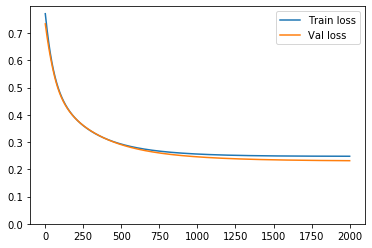

In [25]:
plot_loss_vs_epochs(train_losess, val_losses)

**Plot auc vs epochs**

**The trend is positive until plateau on the train & validation set. As we can see the validation and the train making the same results. We can assume that the data is very simple and the size of the validation is very small so maybe it is not representing data of the usecase *

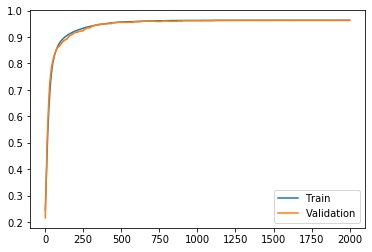

In [26]:
plot_auc_vs_epochs(roc_auc_train, roc_auc_val)

**Plot roc cruve:**

You can see that the drift is on the stairs.
In each step we can select the leftmost point in the step by preserving the false positive we are willing to allow.

The test auc is: 0.91


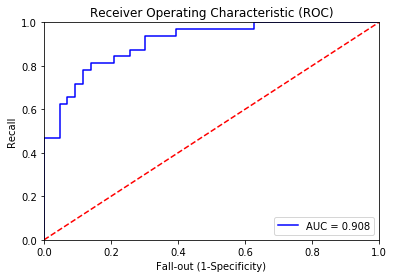

In [33]:
plot_roc_cruve(y_test=y_test, y_pred_p=y_pred_p)

Plot decision boundary:

Test Accuracy 0.84


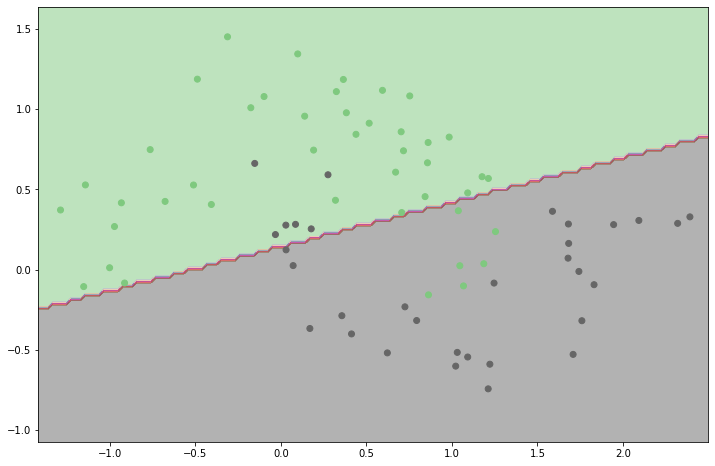

In [34]:
plot_decision_boundary(x, x_test, y_test, net)

**Question:** 

Is the decision boundary linear or nonlinear in the case of a logistic regression? Explain.

**Answer:**

**Type your answer here:**

When applying a sigmoid function on a linear function, we get a non linear function. If we choose  a constant threshold to this outcome - the decision boundary is linear

# Classification with Neural Networks

After you implemented "classical" logistic regression, now you will be implementing a neural network with one or more hidden layers.
You will need to choose the number of hidden layers and nodes in a feedforward neural network, activation function, the type of optimizer and its hyperparmeters which will give you the best result. Remember, we don't want to overfit the training data, we want to generalize the solution for new data not seen during training. 

Plot the same graphs as in the previous sections and explain the similarities and differences. 

**Define the Model:**

In [35]:
training_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test)
net = MlpNetwork(num_net_channels_part_b, nn.Sigmoid(), classifier=True)
opt = torch.optim.Adam
criterion = nn.BCELoss

In [36]:
print("Loss before train on the Test set:")
print(infer(net, test_generator))
print("Accuracy before train:")
_ = test_accuracy(net, x_test, y_test)

Loss before train on the Test set:
0.6999
Accuracy before train:
0.57


**Training and validation:**

In [37]:
train_losess, val_losses, roc_auc_train, roc_auc_val = train(net, training_generator, validation_generator, verbose=True,
                                                             opt_func=opt, criterion_func=criterion, epochs=num_epochs,
                                                             lr=0.01, check_early_stopping=True, check_auc_roc=True)

Epoch: 1/2000... Step: 1... Loss: 0.72138... Val Loss: 0.72877
Epoch: 2/2000... Step: 2... Loss: 0.71296... Val Loss: 0.71479
Epoch: 3/2000... Step: 3... Loss: 0.70600... Val Loss: 0.70294
Epoch: 4/2000... Step: 4... Loss: 0.70028... Val Loss: 0.69319
Epoch: 5/2000... Step: 5... Loss: 0.69536... Val Loss: 0.68518
Epoch: 6/2000... Step: 6... Loss: 0.69078... Val Loss: 0.67850
Epoch: 7/2000... Step: 7... Loss: 0.68627... Val Loss: 0.67281
Epoch: 8/2000... Step: 8... Loss: 0.68170... Val Loss: 0.66787
Epoch: 9/2000... Step: 9... Loss: 0.67702... Val Loss: 0.66349
Epoch: 10/2000... Step: 10... Loss: 0.67224... Val Loss: 0.65955
Epoch: 11/2000... Step: 11... Loss: 0.66742... Val Loss: 0.65594
Epoch: 12/2000... Step: 12... Loss: 0.66258... Val Loss: 0.65254
Epoch: 13/2000... Step: 13... Loss: 0.65778... Val Loss: 0.64923
Epoch: 14/2000... Step: 14... Loss: 0.65301... Val Loss: 0.64590
Epoch: 15/2000... Step: 15... Loss: 0.64828... Val Loss: 0.64241
Epoch: 16/2000... Step: 16... Loss: 0.64355

Epoch: 135/2000... Step: 135... Loss: 0.25774... Val Loss: 0.24440
Epoch: 136/2000... Step: 136... Loss: 0.25741... Val Loss: 0.24392
Epoch: 137/2000... Step: 137... Loss: 0.25710... Val Loss: 0.24347
Epoch: 138/2000... Step: 138... Loss: 0.25681... Val Loss: 0.24304
Epoch: 139/2000... Step: 139... Loss: 0.25652... Val Loss: 0.24263
Epoch: 140/2000... Step: 140... Loss: 0.25625... Val Loss: 0.24223
Epoch: 141/2000... Step: 141... Loss: 0.25599... Val Loss: 0.24185
Epoch: 142/2000... Step: 142... Loss: 0.25573... Val Loss: 0.24149
Epoch: 143/2000... Step: 143... Loss: 0.25549... Val Loss: 0.24115
Epoch: 144/2000... Step: 144... Loss: 0.25526... Val Loss: 0.24082
Epoch: 145/2000... Step: 145... Loss: 0.25504... Val Loss: 0.24050
Epoch: 146/2000... Step: 146... Loss: 0.25483... Val Loss: 0.24020
Epoch: 147/2000... Step: 147... Loss: 0.25463... Val Loss: 0.23991
Epoch: 148/2000... Step: 148... Loss: 0.25444... Val Loss: 0.23964
Epoch: 149/2000... Step: 149... Loss: 0.25425... Val Loss: 0.2

Epoch: 273/2000... Step: 273... Loss: 0.24757... Val Loss: 0.22839
Epoch: 274/2000... Step: 274... Loss: 0.24746... Val Loss: 0.22827
Epoch: 275/2000... Step: 275... Loss: 0.24734... Val Loss: 0.22814
Epoch: 276/2000... Step: 276... Loss: 0.24722... Val Loss: 0.22801
Epoch: 277/2000... Step: 277... Loss: 0.24710... Val Loss: 0.22787
Epoch: 278/2000... Step: 278... Loss: 0.24697... Val Loss: 0.22774
Epoch: 279/2000... Step: 279... Loss: 0.24683... Val Loss: 0.22760
Epoch: 280/2000... Step: 280... Loss: 0.24669... Val Loss: 0.22746
Epoch: 281/2000... Step: 281... Loss: 0.24655... Val Loss: 0.22732
Epoch: 282/2000... Step: 282... Loss: 0.24640... Val Loss: 0.22718
Epoch: 283/2000... Step: 283... Loss: 0.24625... Val Loss: 0.22703
Epoch: 284/2000... Step: 284... Loss: 0.24610... Val Loss: 0.22688
Epoch: 285/2000... Step: 285... Loss: 0.24594... Val Loss: 0.22673
Epoch: 286/2000... Step: 286... Loss: 0.24577... Val Loss: 0.22658
Epoch: 287/2000... Step: 287... Loss: 0.24561... Val Loss: 0.2

Epoch: 411/2000... Step: 411... Loss: 0.20205... Val Loss: 0.18333
Epoch: 412/2000... Step: 412... Loss: 0.20163... Val Loss: 0.18294
Epoch: 413/2000... Step: 413... Loss: 0.20121... Val Loss: 0.18255
Epoch: 414/2000... Step: 414... Loss: 0.20079... Val Loss: 0.18217
Epoch: 415/2000... Step: 415... Loss: 0.20037... Val Loss: 0.18178
Epoch: 416/2000... Step: 416... Loss: 0.19995... Val Loss: 0.18140
Epoch: 417/2000... Step: 417... Loss: 0.19953... Val Loss: 0.18101
Epoch: 418/2000... Step: 418... Loss: 0.19911... Val Loss: 0.18063
Epoch: 419/2000... Step: 419... Loss: 0.19869... Val Loss: 0.18024
Epoch: 420/2000... Step: 420... Loss: 0.19828... Val Loss: 0.17986
Epoch: 421/2000... Step: 421... Loss: 0.19786... Val Loss: 0.17948
Epoch: 422/2000... Step: 422... Loss: 0.19744... Val Loss: 0.17910
Epoch: 423/2000... Step: 423... Loss: 0.19703... Val Loss: 0.17872
Epoch: 424/2000... Step: 424... Loss: 0.19661... Val Loss: 0.17834
Epoch: 425/2000... Step: 425... Loss: 0.19620... Val Loss: 0.1

Epoch: 549/2000... Step: 549... Loss: 0.14690... Val Loss: 0.13254
Epoch: 550/2000... Step: 550... Loss: 0.14653... Val Loss: 0.13220
Epoch: 551/2000... Step: 551... Loss: 0.14615... Val Loss: 0.13185
Epoch: 552/2000... Step: 552... Loss: 0.14578... Val Loss: 0.13151
Epoch: 553/2000... Step: 553... Loss: 0.14541... Val Loss: 0.13116
Epoch: 554/2000... Step: 554... Loss: 0.14504... Val Loss: 0.13082
Epoch: 555/2000... Step: 555... Loss: 0.14467... Val Loss: 0.13048
Epoch: 556/2000... Step: 556... Loss: 0.14430... Val Loss: 0.13014
Epoch: 557/2000... Step: 557... Loss: 0.14394... Val Loss: 0.12980
Epoch: 558/2000... Step: 558... Loss: 0.14357... Val Loss: 0.12946
Epoch: 559/2000... Step: 559... Loss: 0.14320... Val Loss: 0.12912
Epoch: 560/2000... Step: 560... Loss: 0.14284... Val Loss: 0.12878
Epoch: 561/2000... Step: 561... Loss: 0.14247... Val Loss: 0.12845
Epoch: 562/2000... Step: 562... Loss: 0.14211... Val Loss: 0.12811
Epoch: 563/2000... Step: 563... Loss: 0.14175... Val Loss: 0.1

Epoch: 672/2000... Step: 672... Loss: 0.10859... Val Loss: 0.09630
Epoch: 673/2000... Step: 673... Loss: 0.10834... Val Loss: 0.09606
Epoch: 674/2000... Step: 674... Loss: 0.10810... Val Loss: 0.09583
Epoch: 675/2000... Step: 675... Loss: 0.10786... Val Loss: 0.09559
Epoch: 676/2000... Step: 676... Loss: 0.10762... Val Loss: 0.09536
Epoch: 677/2000... Step: 677... Loss: 0.10738... Val Loss: 0.09513
Epoch: 678/2000... Step: 678... Loss: 0.10715... Val Loss: 0.09490
Epoch: 679/2000... Step: 679... Loss: 0.10691... Val Loss: 0.09467
Epoch: 680/2000... Step: 680... Loss: 0.10667... Val Loss: 0.09444
Epoch: 681/2000... Step: 681... Loss: 0.10644... Val Loss: 0.09421
Epoch: 682/2000... Step: 682... Loss: 0.10621... Val Loss: 0.09398
Epoch: 683/2000... Step: 683... Loss: 0.10598... Val Loss: 0.09376
Epoch: 684/2000... Step: 684... Loss: 0.10574... Val Loss: 0.09353
Epoch: 685/2000... Step: 685... Loss: 0.10551... Val Loss: 0.09331
Epoch: 686/2000... Step: 686... Loss: 0.10529... Val Loss: 0.0

Epoch: 798/2000... Step: 798... Loss: 0.08528... Val Loss: 0.07306
Epoch: 799/2000... Step: 799... Loss: 0.08515... Val Loss: 0.07292
Epoch: 800/2000... Step: 800... Loss: 0.08501... Val Loss: 0.07278
Epoch: 801/2000... Step: 801... Loss: 0.08488... Val Loss: 0.07264
Epoch: 802/2000... Step: 802... Loss: 0.08474... Val Loss: 0.07250
Epoch: 803/2000... Step: 803... Loss: 0.08461... Val Loss: 0.07236
Epoch: 804/2000... Step: 804... Loss: 0.08448... Val Loss: 0.07222
Epoch: 805/2000... Step: 805... Loss: 0.08435... Val Loss: 0.07208
Epoch: 806/2000... Step: 806... Loss: 0.08422... Val Loss: 0.07194
Epoch: 807/2000... Step: 807... Loss: 0.08409... Val Loss: 0.07180
Epoch: 808/2000... Step: 808... Loss: 0.08396... Val Loss: 0.07166
Epoch: 809/2000... Step: 809... Loss: 0.08383... Val Loss: 0.07153
Epoch: 810/2000... Step: 810... Loss: 0.08370... Val Loss: 0.07139
Epoch: 811/2000... Step: 811... Loss: 0.08357... Val Loss: 0.07125
Epoch: 812/2000... Step: 812... Loss: 0.08344... Val Loss: 0.0

Epoch: 923/2000... Step: 923... Loss: 0.07246... Val Loss: 0.05868
Epoch: 924/2000... Step: 924... Loss: 0.07238... Val Loss: 0.05858
Epoch: 925/2000... Step: 925... Loss: 0.07231... Val Loss: 0.05849
Epoch: 926/2000... Step: 926... Loss: 0.07223... Val Loss: 0.05840
Epoch: 927/2000... Step: 927... Loss: 0.07216... Val Loss: 0.05831
Epoch: 928/2000... Step: 928... Loss: 0.07209... Val Loss: 0.05822
Epoch: 929/2000... Step: 929... Loss: 0.07201... Val Loss: 0.05813
Epoch: 930/2000... Step: 930... Loss: 0.07194... Val Loss: 0.05804
Epoch: 931/2000... Step: 931... Loss: 0.07187... Val Loss: 0.05795
Epoch: 932/2000... Step: 932... Loss: 0.07179... Val Loss: 0.05786
Epoch: 933/2000... Step: 933... Loss: 0.07172... Val Loss: 0.05777
Epoch: 934/2000... Step: 934... Loss: 0.07165... Val Loss: 0.05768
Epoch: 935/2000... Step: 935... Loss: 0.07158... Val Loss: 0.05759
Epoch: 936/2000... Step: 936... Loss: 0.07151... Val Loss: 0.05750
Epoch: 937/2000... Step: 937... Loss: 0.07144... Val Loss: 0.0

Epoch: 1045/2000... Step: 1045... Loss: 0.06537... Val Loss: 0.04948
Epoch: 1046/2000... Step: 1046... Loss: 0.06533... Val Loss: 0.04942
Epoch: 1047/2000... Step: 1047... Loss: 0.06529... Val Loss: 0.04936
Epoch: 1048/2000... Step: 1048... Loss: 0.06524... Val Loss: 0.04930
Epoch: 1049/2000... Step: 1049... Loss: 0.06520... Val Loss: 0.04924
Epoch: 1050/2000... Step: 1050... Loss: 0.06516... Val Loss: 0.04918
Epoch: 1051/2000... Step: 1051... Loss: 0.06511... Val Loss: 0.04912
Epoch: 1052/2000... Step: 1052... Loss: 0.06507... Val Loss: 0.04906
Epoch: 1053/2000... Step: 1053... Loss: 0.06503... Val Loss: 0.04900
Epoch: 1054/2000... Step: 1054... Loss: 0.06498... Val Loss: 0.04894
Epoch: 1055/2000... Step: 1055... Loss: 0.06494... Val Loss: 0.04889
Epoch: 1056/2000... Step: 1056... Loss: 0.06490... Val Loss: 0.04883
Epoch: 1057/2000... Step: 1057... Loss: 0.06486... Val Loss: 0.04877
Epoch: 1058/2000... Step: 1058... Loss: 0.06482... Val Loss: 0.04871
Epoch: 1059/2000... Step: 1059... 

Epoch: 1168/2000... Step: 1168... Loss: 0.06108... Val Loss: 0.04344
Epoch: 1169/2000... Step: 1169... Loss: 0.06105... Val Loss: 0.04340
Epoch: 1170/2000... Step: 1170... Loss: 0.06102... Val Loss: 0.04336
Epoch: 1171/2000... Step: 1171... Loss: 0.06100... Val Loss: 0.04332
Epoch: 1172/2000... Step: 1172... Loss: 0.06097... Val Loss: 0.04328
Epoch: 1173/2000... Step: 1173... Loss: 0.06094... Val Loss: 0.04324
Epoch: 1174/2000... Step: 1174... Loss: 0.06091... Val Loss: 0.04321
Epoch: 1175/2000... Step: 1175... Loss: 0.06089... Val Loss: 0.04317
Epoch: 1176/2000... Step: 1176... Loss: 0.06086... Val Loss: 0.04313
Epoch: 1177/2000... Step: 1177... Loss: 0.06083... Val Loss: 0.04309
Epoch: 1178/2000... Step: 1178... Loss: 0.06081... Val Loss: 0.04305
Epoch: 1179/2000... Step: 1179... Loss: 0.06078... Val Loss: 0.04301
Epoch: 1180/2000... Step: 1180... Loss: 0.06075... Val Loss: 0.04298
Epoch: 1181/2000... Step: 1181... Loss: 0.06073... Val Loss: 0.04294
Epoch: 1182/2000... Step: 1182... 

Epoch: 1292/2000... Step: 1292... Loss: 0.05828... Val Loss: 0.03948
Epoch: 1293/2000... Step: 1293... Loss: 0.05827... Val Loss: 0.03945
Epoch: 1294/2000... Step: 1294... Loss: 0.05825... Val Loss: 0.03943
Epoch: 1295/2000... Step: 1295... Loss: 0.05823... Val Loss: 0.03940
Epoch: 1296/2000... Step: 1296... Loss: 0.05821... Val Loss: 0.03938
Epoch: 1297/2000... Step: 1297... Loss: 0.05819... Val Loss: 0.03935
Epoch: 1298/2000... Step: 1298... Loss: 0.05817... Val Loss: 0.03933
Epoch: 1299/2000... Step: 1299... Loss: 0.05816... Val Loss: 0.03930
Epoch: 1300/2000... Step: 1300... Loss: 0.05814... Val Loss: 0.03928
Epoch: 1301/2000... Step: 1301... Loss: 0.05812... Val Loss: 0.03925
Epoch: 1302/2000... Step: 1302... Loss: 0.05810... Val Loss: 0.03923
Epoch: 1303/2000... Step: 1303... Loss: 0.05808... Val Loss: 0.03920
Epoch: 1304/2000... Step: 1304... Loss: 0.05807... Val Loss: 0.03918
Epoch: 1305/2000... Step: 1305... Loss: 0.05805... Val Loss: 0.03915
Epoch: 1306/2000... Step: 1306... 

Epoch: 1419/2000... Step: 1419... Loss: 0.05630... Val Loss: 0.03682
Epoch: 1420/2000... Step: 1420... Loss: 0.05629... Val Loss: 0.03680
Epoch: 1421/2000... Step: 1421... Loss: 0.05627... Val Loss: 0.03678
Epoch: 1422/2000... Step: 1422... Loss: 0.05626... Val Loss: 0.03677
Epoch: 1423/2000... Step: 1423... Loss: 0.05625... Val Loss: 0.03675
Epoch: 1424/2000... Step: 1424... Loss: 0.05623... Val Loss: 0.03673
Epoch: 1425/2000... Step: 1425... Loss: 0.05622... Val Loss: 0.03672
Epoch: 1426/2000... Step: 1426... Loss: 0.05621... Val Loss: 0.03670
Epoch: 1427/2000... Step: 1427... Loss: 0.05620... Val Loss: 0.03668
Epoch: 1428/2000... Step: 1428... Loss: 0.05618... Val Loss: 0.03667
Epoch: 1429/2000... Step: 1429... Loss: 0.05617... Val Loss: 0.03665
Epoch: 1430/2000... Step: 1430... Loss: 0.05616... Val Loss: 0.03663
Epoch: 1431/2000... Step: 1431... Loss: 0.05614... Val Loss: 0.03662
Epoch: 1432/2000... Step: 1432... Loss: 0.05613... Val Loss: 0.03660
Epoch: 1433/2000... Step: 1433... 

Epoch: 1538/2000... Step: 1538... Loss: 0.05491... Val Loss: 0.03513
Epoch: 1539/2000... Step: 1539... Loss: 0.05490... Val Loss: 0.03512
Epoch: 1540/2000... Step: 1540... Loss: 0.05489... Val Loss: 0.03511
Epoch: 1541/2000... Step: 1541... Loss: 0.05488... Val Loss: 0.03510
Epoch: 1542/2000... Step: 1542... Loss: 0.05486... Val Loss: 0.03509
Epoch: 1543/2000... Step: 1543... Loss: 0.05485... Val Loss: 0.03508
Epoch: 1544/2000... Step: 1544... Loss: 0.05484... Val Loss: 0.03506
Epoch: 1545/2000... Step: 1545... Loss: 0.05483... Val Loss: 0.03505
Epoch: 1546/2000... Step: 1546... Loss: 0.05482... Val Loss: 0.03504
Epoch: 1547/2000... Step: 1547... Loss: 0.05481... Val Loss: 0.03503
Epoch: 1548/2000... Step: 1548... Loss: 0.05480... Val Loss: 0.03502
Epoch: 1549/2000... Step: 1549... Loss: 0.05479... Val Loss: 0.03501
Epoch: 1550/2000... Step: 1550... Loss: 0.05478... Val Loss: 0.03500
Epoch: 1551/2000... Step: 1551... Loss: 0.05477... Val Loss: 0.03499
Epoch: 1552/2000... Step: 1552... 

EarlyStopping counter: 1 out of 30
Epoch: 1652/2000... Step: 1652... Loss: 0.05383... Val Loss: 0.03401
Epoch: 1653/2000... Step: 1653... Loss: 0.05382... Val Loss: 0.03400
EarlyStopping counter: 1 out of 30
Epoch: 1654/2000... Step: 1654... Loss: 0.05381... Val Loss: 0.03399
Epoch: 1655/2000... Step: 1655... Loss: 0.05380... Val Loss: 0.03398
EarlyStopping counter: 1 out of 30
Epoch: 1656/2000... Step: 1656... Loss: 0.05379... Val Loss: 0.03398
Epoch: 1657/2000... Step: 1657... Loss: 0.05378... Val Loss: 0.03397
EarlyStopping counter: 1 out of 30
Epoch: 1658/2000... Step: 1658... Loss: 0.05377... Val Loss: 0.03396
Epoch: 1659/2000... Step: 1659... Loss: 0.05376... Val Loss: 0.03395
EarlyStopping counter: 1 out of 30
Epoch: 1660/2000... Step: 1660... Loss: 0.05376... Val Loss: 0.03394
Epoch: 1661/2000... Step: 1661... Loss: 0.05375... Val Loss: 0.03394
EarlyStopping counter: 1 out of 30
Epoch: 1662/2000... Step: 1662... Loss: 0.05374... Val Loss: 0.03393
Epoch: 1663/2000... Step: 1663.

EarlyStopping counter: 1 out of 30
Epoch: 1756/2000... Step: 1756... Loss: 0.05297... Val Loss: 0.03327
Epoch: 1757/2000... Step: 1757... Loss: 0.05297... Val Loss: 0.03327
EarlyStopping counter: 1 out of 30
Epoch: 1758/2000... Step: 1758... Loss: 0.05296... Val Loss: 0.03326
Epoch: 1759/2000... Step: 1759... Loss: 0.05295... Val Loss: 0.03326
EarlyStopping counter: 1 out of 30
Epoch: 1760/2000... Step: 1760... Loss: 0.05294... Val Loss: 0.03325
Epoch: 1761/2000... Step: 1761... Loss: 0.05294... Val Loss: 0.03324
EarlyStopping counter: 1 out of 30
Epoch: 1762/2000... Step: 1762... Loss: 0.05293... Val Loss: 0.03324
Epoch: 1763/2000... Step: 1763... Loss: 0.05292... Val Loss: 0.03323
EarlyStopping counter: 1 out of 30
Epoch: 1764/2000... Step: 1764... Loss: 0.05291... Val Loss: 0.03323
Epoch: 1765/2000... Step: 1765... Loss: 0.05290... Val Loss: 0.03322
EarlyStopping counter: 1 out of 30
Epoch: 1766/2000... Step: 1766... Loss: 0.05290... Val Loss: 0.03322
Epoch: 1767/2000... Step: 1767.

EarlyStopping counter: 2 out of 30
Epoch: 1855/2000... Step: 1855... Loss: 0.05223... Val Loss: 0.03277
Epoch: 1856/2000... Step: 1856... Loss: 0.05222... Val Loss: 0.03277
EarlyStopping counter: 1 out of 30
Epoch: 1857/2000... Step: 1857... Loss: 0.05222... Val Loss: 0.03276
EarlyStopping counter: 2 out of 30
Epoch: 1858/2000... Step: 1858... Loss: 0.05221... Val Loss: 0.03276
Epoch: 1859/2000... Step: 1859... Loss: 0.05220... Val Loss: 0.03275
EarlyStopping counter: 1 out of 30
Epoch: 1860/2000... Step: 1860... Loss: 0.05220... Val Loss: 0.03275
EarlyStopping counter: 2 out of 30
Epoch: 1861/2000... Step: 1861... Loss: 0.05219... Val Loss: 0.03275
Epoch: 1862/2000... Step: 1862... Loss: 0.05218... Val Loss: 0.03274
EarlyStopping counter: 1 out of 30
Epoch: 1863/2000... Step: 1863... Loss: 0.05217... Val Loss: 0.03274
EarlyStopping counter: 2 out of 30
Epoch: 1864/2000... Step: 1864... Loss: 0.05217... Val Loss: 0.03273
Epoch: 1865/2000... Step: 1865... Loss: 0.05216... Val Loss: 0.03

Epoch: 1943/2000... Step: 1943... Loss: 0.05159... Val Loss: 0.03245
EarlyStopping counter: 1 out of 30
Epoch: 1944/2000... Step: 1944... Loss: 0.05158... Val Loss: 0.03245
EarlyStopping counter: 2 out of 30
Epoch: 1945/2000... Step: 1945... Loss: 0.05158... Val Loss: 0.03245
EarlyStopping counter: 3 out of 30
Epoch: 1946/2000... Step: 1946... Loss: 0.05157... Val Loss: 0.03244
Epoch: 1947/2000... Step: 1947... Loss: 0.05156... Val Loss: 0.03244
EarlyStopping counter: 1 out of 30
Epoch: 1948/2000... Step: 1948... Loss: 0.05155... Val Loss: 0.03244
EarlyStopping counter: 2 out of 30
Epoch: 1949/2000... Step: 1949... Loss: 0.05155... Val Loss: 0.03244
EarlyStopping counter: 3 out of 30
Epoch: 1950/2000... Step: 1950... Loss: 0.05154... Val Loss: 0.03243
Epoch: 1951/2000... Step: 1951... Loss: 0.05153... Val Loss: 0.03243
EarlyStopping counter: 1 out of 30
Epoch: 1952/2000... Step: 1952... Loss: 0.05152... Val Loss: 0.03243
EarlyStopping counter: 2 out of 30
Epoch: 1953/2000... Step: 1953

In [38]:
print("Loss after training on the Test set: {}".format(infer(net, test_generator)))
print("Accuracy After training on the Test set:")
y_pred_p = test_accuracy(net, x_test, y_test)

Loss after training on the Test set: 0.1283
Accuracy After training on the Test set:
0.96


**Results**: <br>
We can see that the loss on the test set in this model is lower from the loss in the fisrt model (0.69 vs 0.07) <br>
In addition we see that the accuracy is better in the current model.

**Visualizing the plots:**

Plot loss vs epochs part b

The train and the validation in this model are lower and going down very fast

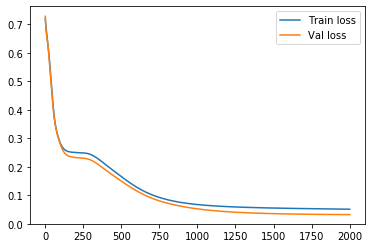

In [39]:
plot_loss_vs_epochs(train_losess, val_losses)

Plot auc vs epochs part b

In this model the Auc was very high faster than the provious model

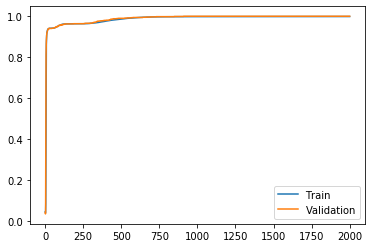

In [40]:
plot_auc_vs_epochs(roc_auc_train, roc_auc_val)

Plot roc cruve part b

The auc aimed at 1 much faster than the previous model

The test auc is: 0.99


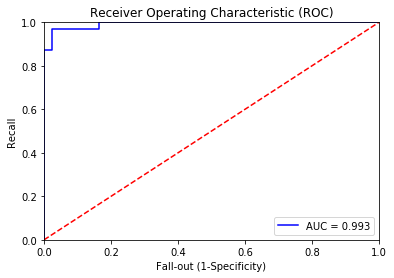

In [41]:
plot_roc_cruve(y_test=y_test, y_pred_p=y_pred_p)

Plot decision boundary part b. <br>
The diffrence between the models is that the first model tried to classify the data in their middle. <br>
The second model try to classify all te blue point.


Test Accuracy 0.96


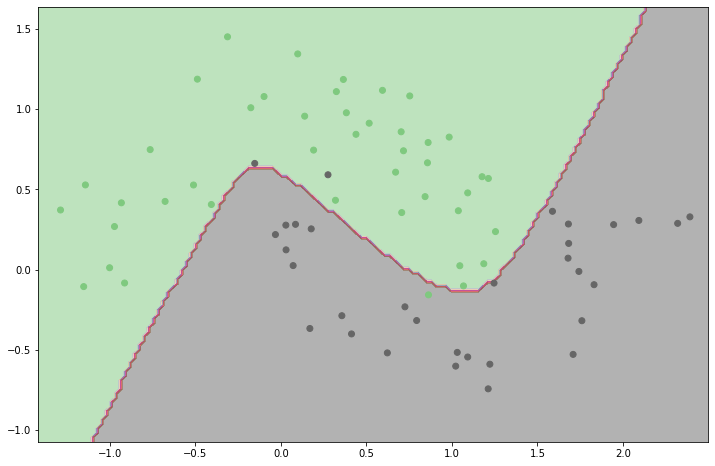

In [42]:
plot_decision_boundary(x, x_test, y_test, net)

# Regression with Neural Networks

In this part of the excercise you will need to implement a regression model using neural networks. The model should predict the output of a trigonometric function of two variables. Your data set is based on a meshgrid. Your task is to create a list of points that would correspond to a grid and use it for the input of your neural network. Then, build your neural networks and find the architecture which gives you the best results.
1. Plot the surface from the overall data and compare it to your predicted test sets.
2. Which loss function and validation metric did you choose?
3. Plot the loss and validation metrics vs epoch for the training and test sets.
4. Build a new neural network and try overfitting your training set. Show that you managed to overfit. Explain.

# Packages 

First import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [43]:
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm

**Generate data:**

In [44]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

In [45]:
xx = xx.flatten()
yy = yy.flatten()
targets = z.flatten()

In [46]:
inputs = np.concatenate((xx.reshape(-1,1), yy.reshape(-1,1)), axis=1)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.15, random_state=random_num)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=random_num)

In [48]:
# Create generators for the data
training_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test)

**Define the Model:**

***We choose the MSE Metric for the loss function*** as at a regression tasks we need to fit the model with the lowest difference between the continuous value y we predict and the true y. The MSE is substracting the y_pred from the y_true and make it squared - to emphasize big errors.

In [49]:
net = MlpNetwork(num_net_channels_part_c_1, nn.ReLU(), classifier=False)
opt = torch.optim.Adam
criterion = nn.MSELoss

In [50]:
print("Loss before train on the Test set:")
print(infer(net, test_generator, nn.MSELoss))

Loss before train on the Test set:
0.2949


**Training and validation:**

In [51]:
train_losess, val_losses = train(net, training_generator, validation_generator, verbose=True,
                                                             opt_func=opt, criterion_func=criterion, epochs=num_epochs,
                                                             lr=0.01, check_early_stopping=True, check_auc_roc=False)

Epoch: 1/2000... Step: 1... Loss: 0.26484... Val Loss: 0.46755
Epoch: 2/2000... Step: 2... Loss: 0.51327... Val Loss: 0.26363
EarlyStopping counter: 1 out of 30
Epoch: 3/2000... Step: 3... Loss: 0.26608... Val Loss: 0.30823
EarlyStopping counter: 2 out of 30
Epoch: 4/2000... Step: 4... Loss: 0.30715... Val Loss: 0.27449
Epoch: 5/2000... Step: 5... Loss: 0.27488... Val Loss: 0.25244
Epoch: 6/2000... Step: 6... Loss: 0.25439... Val Loss: 0.24523
Epoch: 7/2000... Step: 7... Loss: 0.24969... Val Loss: 0.24322
Epoch: 8/2000... Step: 8... Loss: 0.25064... Val Loss: 0.24129
Epoch: 9/2000... Step: 9... Loss: 0.24935... Val Loss: 0.23754
Epoch: 10/2000... Step: 10... Loss: 0.24590... Val Loss: 0.23385
Epoch: 11/2000... Step: 11... Loss: 0.24241... Val Loss: 0.23120
Epoch: 12/2000... Step: 12... Loss: 0.23970... Val Loss: 0.22914
Epoch: 13/2000... Step: 13... Loss: 0.23774... Val Loss: 0.22670
Epoch: 14/2000... Step: 14... Loss: 0.23595... Val Loss: 0.22384
Epoch: 15/2000... Step: 15... Loss: 0.

EarlyStopping counter: 2 out of 30
Epoch: 111/2000... Step: 111... Loss: 0.04168... Val Loss: 0.04877
Epoch: 112/2000... Step: 112... Loss: 0.04197... Val Loss: 0.04280
EarlyStopping counter: 1 out of 30
Epoch: 113/2000... Step: 113... Loss: 0.04285... Val Loss: 0.04652
EarlyStopping counter: 2 out of 30
Epoch: 114/2000... Step: 114... Loss: 0.04069... Val Loss: 0.04617
Epoch: 115/2000... Step: 115... Loss: 0.03934... Val Loss: 0.04038
EarlyStopping counter: 1 out of 30
Epoch: 116/2000... Step: 116... Loss: 0.03982... Val Loss: 0.04307
EarlyStopping counter: 2 out of 30
Epoch: 117/2000... Step: 117... Loss: 0.03744... Val Loss: 0.04124
Epoch: 118/2000... Step: 118... Loss: 0.03633... Val Loss: 0.03785
EarlyStopping counter: 1 out of 30
Epoch: 119/2000... Step: 119... Loss: 0.03665... Val Loss: 0.04102
Epoch: 120/2000... Step: 120... Loss: 0.03548... Val Loss: 0.03776
Epoch: 121/2000... Step: 121... Loss: 0.03433... Val Loss: 0.03688
EarlyStopping counter: 1 out of 30
Epoch: 122/2000...

EarlyStopping counter: 3 out of 30
Epoch: 208/2000... Step: 208... Loss: 0.01704... Val Loss: 0.01864
EarlyStopping counter: 4 out of 30
Epoch: 209/2000... Step: 209... Loss: 0.01676... Val Loss: 0.01869
EarlyStopping counter: 5 out of 30
Epoch: 210/2000... Step: 210... Loss: 0.01693... Val Loss: 0.01942
EarlyStopping counter: 6 out of 30
Epoch: 211/2000... Step: 211... Loss: 0.01758... Val Loss: 0.01999
EarlyStopping counter: 7 out of 30
Epoch: 212/2000... Step: 212... Loss: 0.01860... Val Loss: 0.02182
EarlyStopping counter: 8 out of 30
Epoch: 213/2000... Step: 213... Loss: 0.01982... Val Loss: 0.02378
EarlyStopping counter: 9 out of 30
Epoch: 214/2000... Step: 214... Loss: 0.02267... Val Loss: 0.02802
EarlyStopping counter: 10 out of 30
Epoch: 215/2000... Step: 215... Loss: 0.02487... Val Loss: 0.02592
EarlyStopping counter: 11 out of 30
Epoch: 216/2000... Step: 216... Loss: 0.02621... Val Loss: 0.02609
EarlyStopping counter: 12 out of 30
Epoch: 217/2000... Step: 217... Loss: 0.0223

EarlyStopping counter: 2 out of 30
Epoch: 294/2000... Step: 294... Loss: 0.01244... Val Loss: 0.01411
EarlyStopping counter: 3 out of 30
Epoch: 295/2000... Step: 295... Loss: 0.01298... Val Loss: 0.01620
EarlyStopping counter: 4 out of 30
Epoch: 296/2000... Step: 296... Loss: 0.01454... Val Loss: 0.01652
EarlyStopping counter: 5 out of 30
Epoch: 297/2000... Step: 297... Loss: 0.01476... Val Loss: 0.01671
EarlyStopping counter: 6 out of 30
Epoch: 298/2000... Step: 298... Loss: 0.01453... Val Loss: 0.01353
EarlyStopping counter: 7 out of 30
Epoch: 299/2000... Step: 299... Loss: 0.01253... Val Loss: 0.01281
EarlyStopping counter: 8 out of 30
Epoch: 300/2000... Step: 300... Loss: 0.01089... Val Loss: 0.01321
EarlyStopping counter: 9 out of 30
Epoch: 301/2000... Step: 301... Loss: 0.01110... Val Loss: 0.01408
EarlyStopping counter: 10 out of 30
Epoch: 302/2000... Step: 302... Loss: 0.01235... Val Loss: 0.01400
EarlyStopping counter: 11 out of 30
Epoch: 303/2000... Step: 303... Loss: 0.01198

EarlyStopping counter: 8 out of 30
Epoch: 378/2000... Step: 378... Loss: 0.01234... Val Loss: 0.01779
EarlyStopping counter: 9 out of 30
Epoch: 379/2000... Step: 379... Loss: 0.01722... Val Loss: 0.02853
EarlyStopping counter: 10 out of 30
Epoch: 380/2000... Step: 380... Loss: 0.02451... Val Loss: 0.01804
EarlyStopping counter: 11 out of 30
Epoch: 381/2000... Step: 381... Loss: 0.01663... Val Loss: 0.01165
EarlyStopping counter: 12 out of 30
Epoch: 382/2000... Step: 382... Loss: 0.00972... Val Loss: 0.01482
EarlyStopping counter: 13 out of 30
Epoch: 383/2000... Step: 383... Loss: 0.01213... Val Loss: 0.01561
EarlyStopping counter: 14 out of 30
Epoch: 384/2000... Step: 384... Loss: 0.01248... Val Loss: 0.01270
EarlyStopping counter: 15 out of 30
Epoch: 385/2000... Step: 385... Loss: 0.01075... Val Loss: 0.01388
EarlyStopping counter: 16 out of 30
Epoch: 386/2000... Step: 386... Loss: 0.01244... Val Loss: 0.01307
EarlyStopping counter: 17 out of 30
Epoch: 387/2000... Step: 387... Loss: 0

EarlyStopping counter: 1 out of 30
Epoch: 468/2000... Step: 468... Loss: 0.00369... Val Loss: 0.00501
EarlyStopping counter: 2 out of 30
Epoch: 469/2000... Step: 469... Loss: 0.00398... Val Loss: 0.00605
EarlyStopping counter: 3 out of 30
Epoch: 470/2000... Step: 470... Loss: 0.00443... Val Loss: 0.00565
EarlyStopping counter: 4 out of 30
Epoch: 471/2000... Step: 471... Loss: 0.00464... Val Loss: 0.00628
EarlyStopping counter: 5 out of 30
Epoch: 472/2000... Step: 472... Loss: 0.00480... Val Loss: 0.00582
EarlyStopping counter: 6 out of 30
Epoch: 473/2000... Step: 473... Loss: 0.00470... Val Loss: 0.00649
EarlyStopping counter: 7 out of 30
Epoch: 474/2000... Step: 474... Loss: 0.00497... Val Loss: 0.00606
EarlyStopping counter: 8 out of 30
Epoch: 475/2000... Step: 475... Loss: 0.00511... Val Loss: 0.00691
EarlyStopping counter: 9 out of 30
Epoch: 476/2000... Step: 476... Loss: 0.00531... Val Loss: 0.00599
EarlyStopping counter: 10 out of 30
Epoch: 477/2000... Step: 477... Loss: 0.00511.

In [52]:
print("Loss after train on the Test set:")
print(infer(net, test_generator, nn.MSELoss))

Loss after train on the Test set:
0.0041


**Visualizing the plots:**

Plot the mse loss and compare the train and validation loss.

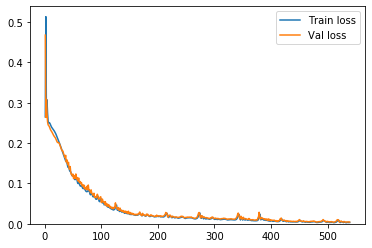

In [53]:
plot_loss_vs_epochs(train_losess, val_losses)

### Build a new neural network and try overfitting your training set

**Generate data:**

In [54]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

In [55]:
xx = xx.flatten()
yy = yy.flatten()
targets = z.flatten()

In [56]:
inputs = np.concatenate((xx.reshape(-1,1), yy.reshape(-1,1)), axis=1)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.15, random_state=random_num)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=random_num)

In [58]:
# Create generators for the data
training_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test)

**Define the Model:**

In [59]:
net = MlpNetwork(num_net_channels_part_c_2, nn.ReLU(), classifier=False)
opt = torch.optim.Adam
criterion = nn.MSELoss

**Training and validation:**

In [60]:
### START CODE HERE ###
train_losess, val_losses = train(net, training_generator, validation_generator, verbose=True,
                                                             opt_func=opt, criterion_func=criterion, epochs=num_epochs,
                                                             lr=0.01, check_early_stopping=False, check_auc_roc=False)

Epoch: 1/2000... Step: 1... Loss: 0.26069... Val Loss: 0.48543
Epoch: 2/2000... Step: 2... Loss: 0.46874... Val Loss: 0.37832
Epoch: 3/2000... Step: 3... Loss: 0.42838... Val Loss: 0.23399
EarlyStopping counter: 1 out of 30
Epoch: 4/2000... Step: 4... Loss: 0.25682... Val Loss: 0.35048
EarlyStopping counter: 2 out of 30
Epoch: 5/2000... Step: 5... Loss: 0.34755... Val Loss: 0.23783
EarlyStopping counter: 3 out of 30
Epoch: 6/2000... Step: 6... Loss: 0.25191... Val Loss: 0.23402
Epoch: 7/2000... Step: 7... Loss: 0.25144... Val Loss: 0.23378
EarlyStopping counter: 1 out of 30
Epoch: 8/2000... Step: 8... Loss: 0.25129... Val Loss: 0.23421
EarlyStopping counter: 2 out of 30
Epoch: 9/2000... Step: 9... Loss: 0.25092... Val Loss: 0.23388
Epoch: 10/2000... Step: 10... Loss: 0.24954... Val Loss: 0.23291
Epoch: 11/2000... Step: 11... Loss: 0.24776... Val Loss: 0.23031
Epoch: 12/2000... Step: 12... Loss: 0.24554... Val Loss: 0.22720
Epoch: 13/2000... Step: 13... Loss: 0.24284... Val Loss: 0.2239

EarlyStopping counter: 2 out of 30
Epoch: 103/2000... Step: 103... Loss: 0.01267... Val Loss: 0.01479
Epoch: 104/2000... Step: 104... Loss: 0.01231... Val Loss: 0.01376
EarlyStopping counter: 1 out of 30
Epoch: 105/2000... Step: 105... Loss: 0.01192... Val Loss: 0.01385
EarlyStopping counter: 2 out of 30
Epoch: 106/2000... Step: 106... Loss: 0.01185... Val Loss: 0.01384
EarlyStopping counter: 3 out of 30
Epoch: 107/2000... Step: 107... Loss: 0.01175... Val Loss: 0.01424
EarlyStopping counter: 4 out of 30
Epoch: 108/2000... Step: 108... Loss: 0.01226... Val Loss: 0.01607
EarlyStopping counter: 5 out of 30
Epoch: 109/2000... Step: 109... Loss: 0.01403... Val Loss: 0.02184
EarlyStopping counter: 6 out of 30
Epoch: 110/2000... Step: 110... Loss: 0.02015... Val Loss: 0.03331
EarlyStopping counter: 7 out of 30
Epoch: 111/2000... Step: 111... Loss: 0.03150... Val Loss: 0.04512
EarlyStopping counter: 8 out of 30
Epoch: 112/2000... Step: 112... Loss: 0.04289... Val Loss: 0.02207
EarlyStopping c

EarlyStopping counter: 1 out of 30
Epoch: 192/2000... Step: 192... Loss: 0.00243... Val Loss: 0.00604
EarlyStopping counter: 2 out of 30
Epoch: 193/2000... Step: 193... Loss: 0.00371... Val Loss: 0.00658
EarlyStopping counter: 3 out of 30
Epoch: 194/2000... Step: 194... Loss: 0.00541... Val Loss: 0.00768
EarlyStopping counter: 4 out of 30
Epoch: 195/2000... Step: 195... Loss: 0.00546... Val Loss: 0.00450
EarlyStopping counter: 5 out of 30
Epoch: 196/2000... Step: 196... Loss: 0.00249... Val Loss: 0.00559
EarlyStopping counter: 6 out of 30
Epoch: 197/2000... Step: 197... Loss: 0.00328... Val Loss: 0.00644
EarlyStopping counter: 7 out of 30
Epoch: 198/2000... Step: 198... Loss: 0.00420... Val Loss: 0.00533
EarlyStopping counter: 8 out of 30
Epoch: 199/2000... Step: 199... Loss: 0.00369... Val Loss: 0.00463
EarlyStopping counter: 9 out of 30
Epoch: 200/2000... Step: 200... Loss: 0.00254... Val Loss: 0.00473
EarlyStopping counter: 10 out of 30
Epoch: 201/2000... Step: 201... Loss: 0.00259.

Epoch: 276/2000... Step: 276... Loss: 0.00089... Val Loss: 0.00251
EarlyStopping counter: 1 out of 30
Epoch: 277/2000... Step: 277... Loss: 0.00082... Val Loss: 0.00257
EarlyStopping counter: 2 out of 30
Epoch: 278/2000... Step: 278... Loss: 0.00083... Val Loss: 0.00259
EarlyStopping counter: 3 out of 30
Epoch: 279/2000... Step: 279... Loss: 0.00088... Val Loss: 0.00267
EarlyStopping counter: 4 out of 30
Epoch: 280/2000... Step: 280... Loss: 0.00094... Val Loss: 0.00281
EarlyStopping counter: 5 out of 30
Epoch: 281/2000... Step: 281... Loss: 0.00100... Val Loss: 0.00275
EarlyStopping counter: 6 out of 30
Epoch: 282/2000... Step: 282... Loss: 0.00105... Val Loss: 0.00289
EarlyStopping counter: 7 out of 30
Epoch: 283/2000... Step: 283... Loss: 0.00109... Val Loss: 0.00285
EarlyStopping counter: 8 out of 30
Epoch: 284/2000... Step: 284... Loss: 0.00108... Val Loss: 0.00281
EarlyStopping counter: 9 out of 30
Epoch: 285/2000... Step: 285... Loss: 0.00105... Val Loss: 0.00272
EarlyStopping c

EarlyStopping counter: 12 out of 30
Epoch: 361/2000... Step: 361... Loss: 0.00115... Val Loss: 0.00273
EarlyStopping counter: 13 out of 30
Epoch: 362/2000... Step: 362... Loss: 0.00123... Val Loss: 0.00270
EarlyStopping counter: 14 out of 30
Epoch: 363/2000... Step: 363... Loss: 0.00118... Val Loss: 0.00251
EarlyStopping counter: 15 out of 30
Epoch: 364/2000... Step: 364... Loss: 0.00114... Val Loss: 0.00245
EarlyStopping counter: 16 out of 30
Epoch: 365/2000... Step: 365... Loss: 0.00090... Val Loss: 0.00236
EarlyStopping counter: 17 out of 30
Epoch: 366/2000... Step: 366... Loss: 0.00072... Val Loss: 0.00210
EarlyStopping counter: 18 out of 30
Epoch: 367/2000... Step: 367... Loss: 0.00061... Val Loss: 0.00216
EarlyStopping counter: 19 out of 30
Epoch: 368/2000... Step: 368... Loss: 0.00062... Val Loss: 0.00226
EarlyStopping counter: 20 out of 30
Epoch: 369/2000... Step: 369... Loss: 0.00070... Val Loss: 0.00213
EarlyStopping counter: 21 out of 30
Epoch: 370/2000... Step: 370... Loss:

EarlyStopping counter: 16 out of 30
Epoch: 445/2000... Step: 445... Loss: 0.00055... Val Loss: 0.00197
EarlyStopping counter: 17 out of 30
Epoch: 446/2000... Step: 446... Loss: 0.00056... Val Loss: 0.00208
EarlyStopping counter: 18 out of 30
Epoch: 447/2000... Step: 447... Loss: 0.00058... Val Loss: 0.00212
EarlyStopping counter: 19 out of 30
Epoch: 448/2000... Step: 448... Loss: 0.00057... Val Loss: 0.00197
EarlyStopping counter: 20 out of 30
Epoch: 449/2000... Step: 449... Loss: 0.00055... Val Loss: 0.00204
EarlyStopping counter: 21 out of 30
Epoch: 450/2000... Step: 450... Loss: 0.00053... Val Loss: 0.00199
EarlyStopping counter: 22 out of 30
Epoch: 451/2000... Step: 451... Loss: 0.00055... Val Loss: 0.00214
EarlyStopping counter: 23 out of 30
Epoch: 452/2000... Step: 452... Loss: 0.00063... Val Loss: 0.00207
EarlyStopping counter: 24 out of 30
Epoch: 453/2000... Step: 453... Loss: 0.00070... Val Loss: 0.00246
EarlyStopping counter: 25 out of 30
Epoch: 454/2000... Step: 454... Loss:

EarlyStopping counter: 97 out of 30
Epoch: 526/2000... Step: 526... Loss: 0.00053... Val Loss: 0.00185
EarlyStopping counter: 98 out of 30
Epoch: 527/2000... Step: 527... Loss: 0.00046... Val Loss: 0.00195
EarlyStopping counter: 99 out of 30
Epoch: 528/2000... Step: 528... Loss: 0.00040... Val Loss: 0.00209
EarlyStopping counter: 100 out of 30
Epoch: 529/2000... Step: 529... Loss: 0.00044... Val Loss: 0.00185
EarlyStopping counter: 101 out of 30
Epoch: 530/2000... Step: 530... Loss: 0.00051... Val Loss: 0.00218
EarlyStopping counter: 102 out of 30
Epoch: 531/2000... Step: 531... Loss: 0.00049... Val Loss: 0.00191
EarlyStopping counter: 103 out of 30
Epoch: 532/2000... Step: 532... Loss: 0.00044... Val Loss: 0.00194
EarlyStopping counter: 104 out of 30
Epoch: 533/2000... Step: 533... Loss: 0.00043... Val Loss: 0.00218
EarlyStopping counter: 105 out of 30
Epoch: 534/2000... Step: 534... Loss: 0.00044... Val Loss: 0.00187
EarlyStopping counter: 106 out of 30
Epoch: 535/2000... Step: 535..

EarlyStopping counter: 178 out of 30
Epoch: 607/2000... Step: 607... Loss: 0.00146... Val Loss: 0.00327
EarlyStopping counter: 179 out of 30
Epoch: 608/2000... Step: 608... Loss: 0.00130... Val Loss: 0.00276
EarlyStopping counter: 180 out of 30
Epoch: 609/2000... Step: 609... Loss: 0.00122... Val Loss: 0.00283
EarlyStopping counter: 181 out of 30
Epoch: 610/2000... Step: 610... Loss: 0.00096... Val Loss: 0.00246
EarlyStopping counter: 182 out of 30
Epoch: 611/2000... Step: 611... Loss: 0.00084... Val Loss: 0.00235
EarlyStopping counter: 183 out of 30
Epoch: 612/2000... Step: 612... Loss: 0.00067... Val Loss: 0.00230
EarlyStopping counter: 184 out of 30
Epoch: 613/2000... Step: 613... Loss: 0.00064... Val Loss: 0.00218
EarlyStopping counter: 185 out of 30
Epoch: 614/2000... Step: 614... Loss: 0.00066... Val Loss: 0.00263
EarlyStopping counter: 186 out of 30
Epoch: 615/2000... Step: 615... Loss: 0.00071... Val Loss: 0.00213
EarlyStopping counter: 187 out of 30
Epoch: 616/2000... Step: 61

EarlyStopping counter: 261 out of 30
Epoch: 690/2000... Step: 690... Loss: 0.00043... Val Loss: 0.00217
EarlyStopping counter: 262 out of 30
Epoch: 691/2000... Step: 691... Loss: 0.00048... Val Loss: 0.00231
EarlyStopping counter: 263 out of 30
Epoch: 692/2000... Step: 692... Loss: 0.00052... Val Loss: 0.00222
EarlyStopping counter: 264 out of 30
Epoch: 693/2000... Step: 693... Loss: 0.00062... Val Loss: 0.00266
EarlyStopping counter: 265 out of 30
Epoch: 694/2000... Step: 694... Loss: 0.00076... Val Loss: 0.00252
EarlyStopping counter: 266 out of 30
Epoch: 695/2000... Step: 695... Loss: 0.00100... Val Loss: 0.00334
EarlyStopping counter: 267 out of 30
Epoch: 696/2000... Step: 696... Loss: 0.00136... Val Loss: 0.00331
EarlyStopping counter: 268 out of 30
Epoch: 697/2000... Step: 697... Loss: 0.00181... Val Loss: 0.00443
EarlyStopping counter: 269 out of 30
Epoch: 698/2000... Step: 698... Loss: 0.00247... Val Loss: 0.00462
EarlyStopping counter: 270 out of 30
Epoch: 699/2000... Step: 69

EarlyStopping counter: 345 out of 30
Epoch: 774/2000... Step: 774... Loss: 0.00083... Val Loss: 0.00282
EarlyStopping counter: 346 out of 30
Epoch: 775/2000... Step: 775... Loss: 0.00090... Val Loss: 0.00234
EarlyStopping counter: 347 out of 30
Epoch: 776/2000... Step: 776... Loss: 0.00120... Val Loss: 0.00297
EarlyStopping counter: 348 out of 30
Epoch: 777/2000... Step: 777... Loss: 0.00086... Val Loss: 0.00230
EarlyStopping counter: 349 out of 30
Epoch: 778/2000... Step: 778... Loss: 0.00056... Val Loss: 0.00209
EarlyStopping counter: 350 out of 30
Epoch: 779/2000... Step: 779... Loss: 0.00076... Val Loss: 0.00314
EarlyStopping counter: 351 out of 30
Epoch: 780/2000... Step: 780... Loss: 0.00110... Val Loss: 0.00197
EarlyStopping counter: 352 out of 30
Epoch: 781/2000... Step: 781... Loss: 0.00062... Val Loss: 0.00214
EarlyStopping counter: 353 out of 30
Epoch: 782/2000... Step: 782... Loss: 0.00045... Val Loss: 0.00251
EarlyStopping counter: 354 out of 30
Epoch: 783/2000... Step: 78

EarlyStopping counter: 426 out of 30
Epoch: 855/2000... Step: 855... Loss: 0.00064... Val Loss: 0.00242
EarlyStopping counter: 427 out of 30
Epoch: 856/2000... Step: 856... Loss: 0.00083... Val Loss: 0.00270
EarlyStopping counter: 428 out of 30
Epoch: 857/2000... Step: 857... Loss: 0.00084... Val Loss: 0.00234
EarlyStopping counter: 429 out of 30
Epoch: 858/2000... Step: 858... Loss: 0.00063... Val Loss: 0.00218
EarlyStopping counter: 430 out of 30
Epoch: 859/2000... Step: 859... Loss: 0.00039... Val Loss: 0.00226
EarlyStopping counter: 431 out of 30
Epoch: 860/2000... Step: 860... Loss: 0.00033... Val Loss: 0.00203
EarlyStopping counter: 432 out of 30
Epoch: 861/2000... Step: 861... Loss: 0.00041... Val Loss: 0.00231
EarlyStopping counter: 433 out of 30
Epoch: 862/2000... Step: 862... Loss: 0.00049... Val Loss: 0.00224
EarlyStopping counter: 434 out of 30
Epoch: 863/2000... Step: 863... Loss: 0.00054... Val Loss: 0.00230
EarlyStopping counter: 435 out of 30
Epoch: 864/2000... Step: 86

EarlyStopping counter: 507 out of 30
Epoch: 936/2000... Step: 936... Loss: 0.00058... Val Loss: 0.00259
EarlyStopping counter: 508 out of 30
Epoch: 937/2000... Step: 937... Loss: 0.00055... Val Loss: 0.00213
EarlyStopping counter: 509 out of 30
Epoch: 938/2000... Step: 938... Loss: 0.00061... Val Loss: 0.00252
EarlyStopping counter: 510 out of 30
Epoch: 939/2000... Step: 939... Loss: 0.00053... Val Loss: 0.00222
EarlyStopping counter: 511 out of 30
Epoch: 940/2000... Step: 940... Loss: 0.00047... Val Loss: 0.00221
EarlyStopping counter: 512 out of 30
Epoch: 941/2000... Step: 941... Loss: 0.00042... Val Loss: 0.00229
EarlyStopping counter: 513 out of 30
Epoch: 942/2000... Step: 942... Loss: 0.00048... Val Loss: 0.00202
EarlyStopping counter: 514 out of 30
Epoch: 943/2000... Step: 943... Loss: 0.00045... Val Loss: 0.00222
EarlyStopping counter: 515 out of 30
Epoch: 944/2000... Step: 944... Loss: 0.00039... Val Loss: 0.00211
EarlyStopping counter: 516 out of 30
Epoch: 945/2000... Step: 94

EarlyStopping counter: 586 out of 30
Epoch: 1015/2000... Step: 1015... Loss: 0.00123... Val Loss: 0.00312
EarlyStopping counter: 587 out of 30
Epoch: 1016/2000... Step: 1016... Loss: 0.00162... Val Loss: 0.00421
EarlyStopping counter: 588 out of 30
Epoch: 1017/2000... Step: 1017... Loss: 0.00224... Val Loss: 0.00413
EarlyStopping counter: 589 out of 30
Epoch: 1018/2000... Step: 1018... Loss: 0.00276... Val Loss: 0.00503
EarlyStopping counter: 590 out of 30
Epoch: 1019/2000... Step: 1019... Loss: 0.00323... Val Loss: 0.00474
EarlyStopping counter: 591 out of 30
Epoch: 1020/2000... Step: 1020... Loss: 0.00298... Val Loss: 0.00421
EarlyStopping counter: 592 out of 30
Epoch: 1021/2000... Step: 1021... Loss: 0.00233... Val Loss: 0.00307
EarlyStopping counter: 593 out of 30
Epoch: 1022/2000... Step: 1022... Loss: 0.00112... Val Loss: 0.00231
EarlyStopping counter: 594 out of 30
Epoch: 1023/2000... Step: 1023... Loss: 0.00050... Val Loss: 0.00221
EarlyStopping counter: 595 out of 30
Epoch: 10

EarlyStopping counter: 668 out of 30
Epoch: 1097/2000... Step: 1097... Loss: 0.00138... Val Loss: 0.00245
EarlyStopping counter: 669 out of 30
Epoch: 1098/2000... Step: 1098... Loss: 0.00061... Val Loss: 0.00239
EarlyStopping counter: 670 out of 30
Epoch: 1099/2000... Step: 1099... Loss: 0.00058... Val Loss: 0.00276
EarlyStopping counter: 671 out of 30
Epoch: 1100/2000... Step: 1100... Loss: 0.00106... Val Loss: 0.00286
EarlyStopping counter: 672 out of 30
Epoch: 1101/2000... Step: 1101... Loss: 0.00092... Val Loss: 0.00274
EarlyStopping counter: 673 out of 30
Epoch: 1102/2000... Step: 1102... Loss: 0.00060... Val Loss: 0.00220
EarlyStopping counter: 674 out of 30
Epoch: 1103/2000... Step: 1103... Loss: 0.00061... Val Loss: 0.00274
EarlyStopping counter: 675 out of 30
Epoch: 1104/2000... Step: 1104... Loss: 0.00069... Val Loss: 0.00238
EarlyStopping counter: 676 out of 30
Epoch: 1105/2000... Step: 1105... Loss: 0.00055... Val Loss: 0.00203
EarlyStopping counter: 677 out of 30
Epoch: 11

EarlyStopping counter: 747 out of 30
Epoch: 1176/2000... Step: 1176... Loss: 0.00024... Val Loss: 0.00220
EarlyStopping counter: 748 out of 30
Epoch: 1177/2000... Step: 1177... Loss: 0.00035... Val Loss: 0.00251
EarlyStopping counter: 749 out of 30
Epoch: 1178/2000... Step: 1178... Loss: 0.00046... Val Loss: 0.00239
EarlyStopping counter: 750 out of 30
Epoch: 1179/2000... Step: 1179... Loss: 0.00052... Val Loss: 0.00248
EarlyStopping counter: 751 out of 30
Epoch: 1180/2000... Step: 1180... Loss: 0.00052... Val Loss: 0.00244
EarlyStopping counter: 752 out of 30
Epoch: 1181/2000... Step: 1181... Loss: 0.00049... Val Loss: 0.00222
EarlyStopping counter: 753 out of 30
Epoch: 1182/2000... Step: 1182... Loss: 0.00042... Val Loss: 0.00247
EarlyStopping counter: 754 out of 30
Epoch: 1183/2000... Step: 1183... Loss: 0.00036... Val Loss: 0.00206
EarlyStopping counter: 755 out of 30
Epoch: 1184/2000... Step: 1184... Loss: 0.00031... Val Loss: 0.00250
EarlyStopping counter: 756 out of 30
Epoch: 11

EarlyStopping counter: 825 out of 30
Epoch: 1254/2000... Step: 1254... Loss: 0.00117... Val Loss: 0.00279
EarlyStopping counter: 826 out of 30
Epoch: 1255/2000... Step: 1255... Loss: 0.00108... Val Loss: 0.00311
EarlyStopping counter: 827 out of 30
Epoch: 1256/2000... Step: 1256... Loss: 0.00105... Val Loss: 0.00285
EarlyStopping counter: 828 out of 30
Epoch: 1257/2000... Step: 1257... Loss: 0.00094... Val Loss: 0.00263
EarlyStopping counter: 829 out of 30
Epoch: 1258/2000... Step: 1258... Loss: 0.00084... Val Loss: 0.00269
EarlyStopping counter: 830 out of 30
Epoch: 1259/2000... Step: 1259... Loss: 0.00070... Val Loss: 0.00229
EarlyStopping counter: 831 out of 30
Epoch: 1260/2000... Step: 1260... Loss: 0.00048... Val Loss: 0.00243
EarlyStopping counter: 832 out of 30
Epoch: 1261/2000... Step: 1261... Loss: 0.00034... Val Loss: 0.00211
EarlyStopping counter: 833 out of 30
Epoch: 1262/2000... Step: 1262... Loss: 0.00026... Val Loss: 0.00233
EarlyStopping counter: 834 out of 30
Epoch: 12

EarlyStopping counter: 904 out of 30
Epoch: 1333/2000... Step: 1333... Loss: 0.00027... Val Loss: 0.00210
EarlyStopping counter: 905 out of 30
Epoch: 1334/2000... Step: 1334... Loss: 0.00022... Val Loss: 0.00223
EarlyStopping counter: 906 out of 30
Epoch: 1335/2000... Step: 1335... Loss: 0.00023... Val Loss: 0.00230
EarlyStopping counter: 907 out of 30
Epoch: 1336/2000... Step: 1336... Loss: 0.00025... Val Loss: 0.00217
EarlyStopping counter: 908 out of 30
Epoch: 1337/2000... Step: 1337... Loss: 0.00025... Val Loss: 0.00217
EarlyStopping counter: 909 out of 30
Epoch: 1338/2000... Step: 1338... Loss: 0.00021... Val Loss: 0.00222
EarlyStopping counter: 910 out of 30
Epoch: 1339/2000... Step: 1339... Loss: 0.00019... Val Loss: 0.00210
EarlyStopping counter: 911 out of 30
Epoch: 1340/2000... Step: 1340... Loss: 0.00020... Val Loss: 0.00235
EarlyStopping counter: 912 out of 30
Epoch: 1341/2000... Step: 1341... Loss: 0.00022... Val Loss: 0.00213
EarlyStopping counter: 913 out of 30
Epoch: 13

EarlyStopping counter: 982 out of 30
Epoch: 1411/2000... Step: 1411... Loss: 0.00019... Val Loss: 0.00226
EarlyStopping counter: 983 out of 30
Epoch: 1412/2000... Step: 1412... Loss: 0.00020... Val Loss: 0.00233
EarlyStopping counter: 984 out of 30
Epoch: 1413/2000... Step: 1413... Loss: 0.00023... Val Loss: 0.00221
EarlyStopping counter: 985 out of 30
Epoch: 1414/2000... Step: 1414... Loss: 0.00024... Val Loss: 0.00229
EarlyStopping counter: 986 out of 30
Epoch: 1415/2000... Step: 1415... Loss: 0.00022... Val Loss: 0.00220
EarlyStopping counter: 987 out of 30
Epoch: 1416/2000... Step: 1416... Loss: 0.00020... Val Loss: 0.00212
EarlyStopping counter: 988 out of 30
Epoch: 1417/2000... Step: 1417... Loss: 0.00018... Val Loss: 0.00235
EarlyStopping counter: 989 out of 30
Epoch: 1418/2000... Step: 1418... Loss: 0.00019... Val Loss: 0.00209
EarlyStopping counter: 990 out of 30
Epoch: 1419/2000... Step: 1419... Loss: 0.00021... Val Loss: 0.00239
EarlyStopping counter: 991 out of 30
Epoch: 14

Epoch: 1491/2000... Step: 1491... Loss: 0.00092... Val Loss: 0.00244
EarlyStopping counter: 1063 out of 30
Epoch: 1492/2000... Step: 1492... Loss: 0.00092... Val Loss: 0.00337
EarlyStopping counter: 1064 out of 30
Epoch: 1493/2000... Step: 1493... Loss: 0.00086... Val Loss: 0.00225
EarlyStopping counter: 1065 out of 30
Epoch: 1494/2000... Step: 1494... Loss: 0.00074... Val Loss: 0.00298
EarlyStopping counter: 1066 out of 30
Epoch: 1495/2000... Step: 1495... Loss: 0.00061... Val Loss: 0.00213
EarlyStopping counter: 1067 out of 30
Epoch: 1496/2000... Step: 1496... Loss: 0.00040... Val Loss: 0.00242
EarlyStopping counter: 1068 out of 30
Epoch: 1497/2000... Step: 1497... Loss: 0.00029... Val Loss: 0.00241
EarlyStopping counter: 1069 out of 30
Epoch: 1498/2000... Step: 1498... Loss: 0.00033... Val Loss: 0.00224
EarlyStopping counter: 1070 out of 30
Epoch: 1499/2000... Step: 1499... Loss: 0.00048... Val Loss: 0.00311
EarlyStopping counter: 1071 out of 30
Epoch: 1500/2000... Step: 1500... Los

EarlyStopping counter: 1142 out of 30
Epoch: 1571/2000... Step: 1571... Loss: 0.00022... Val Loss: 0.00227
EarlyStopping counter: 1143 out of 30
Epoch: 1572/2000... Step: 1572... Loss: 0.00021... Val Loss: 0.00215
EarlyStopping counter: 1144 out of 30
Epoch: 1573/2000... Step: 1573... Loss: 0.00018... Val Loss: 0.00217
EarlyStopping counter: 1145 out of 30
Epoch: 1574/2000... Step: 1574... Loss: 0.00016... Val Loss: 0.00227
EarlyStopping counter: 1146 out of 30
Epoch: 1575/2000... Step: 1575... Loss: 0.00018... Val Loss: 0.00215
EarlyStopping counter: 1147 out of 30
Epoch: 1576/2000... Step: 1576... Loss: 0.00019... Val Loss: 0.00226
EarlyStopping counter: 1148 out of 30
Epoch: 1577/2000... Step: 1577... Loss: 0.00018... Val Loss: 0.00219
EarlyStopping counter: 1149 out of 30
Epoch: 1578/2000... Step: 1578... Loss: 0.00017... Val Loss: 0.00222
EarlyStopping counter: 1150 out of 30
Epoch: 1579/2000... Step: 1579... Loss: 0.00017... Val Loss: 0.00220
EarlyStopping counter: 1151 out of 30

EarlyStopping counter: 1221 out of 30
Epoch: 1650/2000... Step: 1650... Loss: 0.00087... Val Loss: 0.00325
EarlyStopping counter: 1222 out of 30
Epoch: 1651/2000... Step: 1651... Loss: 0.00079... Val Loss: 0.00236
EarlyStopping counter: 1223 out of 30
Epoch: 1652/2000... Step: 1652... Loss: 0.00064... Val Loss: 0.00264
EarlyStopping counter: 1224 out of 30
Epoch: 1653/2000... Step: 1653... Loss: 0.00041... Val Loss: 0.00230
EarlyStopping counter: 1225 out of 30
Epoch: 1654/2000... Step: 1654... Loss: 0.00028... Val Loss: 0.00211
EarlyStopping counter: 1226 out of 30
Epoch: 1655/2000... Step: 1655... Loss: 0.00025... Val Loss: 0.00270
EarlyStopping counter: 1227 out of 30
Epoch: 1656/2000... Step: 1656... Loss: 0.00034... Val Loss: 0.00209
EarlyStopping counter: 1228 out of 30
Epoch: 1657/2000... Step: 1657... Loss: 0.00043... Val Loss: 0.00282
EarlyStopping counter: 1229 out of 30
Epoch: 1658/2000... Step: 1658... Loss: 0.00043... Val Loss: 0.00213
EarlyStopping counter: 1230 out of 30

EarlyStopping counter: 1298 out of 30
Epoch: 1727/2000... Step: 1727... Loss: 0.00016... Val Loss: 0.00218
EarlyStopping counter: 1299 out of 30
Epoch: 1728/2000... Step: 1728... Loss: 0.00016... Val Loss: 0.00230
EarlyStopping counter: 1300 out of 30
Epoch: 1729/2000... Step: 1729... Loss: 0.00018... Val Loss: 0.00212
EarlyStopping counter: 1301 out of 30
Epoch: 1730/2000... Step: 1730... Loss: 0.00016... Val Loss: 0.00230
EarlyStopping counter: 1302 out of 30
Epoch: 1731/2000... Step: 1731... Loss: 0.00016... Val Loss: 0.00218
EarlyStopping counter: 1303 out of 30
Epoch: 1732/2000... Step: 1732... Loss: 0.00017... Val Loss: 0.00230
EarlyStopping counter: 1304 out of 30
Epoch: 1733/2000... Step: 1733... Loss: 0.00018... Val Loss: 0.00212
EarlyStopping counter: 1305 out of 30
Epoch: 1734/2000... Step: 1734... Loss: 0.00017... Val Loss: 0.00233
EarlyStopping counter: 1306 out of 30
Epoch: 1735/2000... Step: 1735... Loss: 0.00020... Val Loss: 0.00217
EarlyStopping counter: 1307 out of 30

EarlyStopping counter: 1377 out of 30
Epoch: 1806/2000... Step: 1806... Loss: 0.00016... Val Loss: 0.00230
EarlyStopping counter: 1378 out of 30
Epoch: 1807/2000... Step: 1807... Loss: 0.00015... Val Loss: 0.00220
EarlyStopping counter: 1379 out of 30
Epoch: 1808/2000... Step: 1808... Loss: 0.00015... Val Loss: 0.00236
EarlyStopping counter: 1380 out of 30
Epoch: 1809/2000... Step: 1809... Loss: 0.00016... Val Loss: 0.00219
EarlyStopping counter: 1381 out of 30
Epoch: 1810/2000... Step: 1810... Loss: 0.00017... Val Loss: 0.00239
EarlyStopping counter: 1382 out of 30
Epoch: 1811/2000... Step: 1811... Loss: 0.00017... Val Loss: 0.00222
EarlyStopping counter: 1383 out of 30
Epoch: 1812/2000... Step: 1812... Loss: 0.00017... Val Loss: 0.00233
EarlyStopping counter: 1384 out of 30
Epoch: 1813/2000... Step: 1813... Loss: 0.00018... Val Loss: 0.00230
EarlyStopping counter: 1385 out of 30
Epoch: 1814/2000... Step: 1814... Loss: 0.00018... Val Loss: 0.00225
EarlyStopping counter: 1386 out of 30

EarlyStopping counter: 1458 out of 30
Epoch: 1887/2000... Step: 1887... Loss: 0.00017... Val Loss: 0.00244
EarlyStopping counter: 1459 out of 30
Epoch: 1888/2000... Step: 1888... Loss: 0.00018... Val Loss: 0.00206
EarlyStopping counter: 1460 out of 30
Epoch: 1889/2000... Step: 1889... Loss: 0.00018... Val Loss: 0.00229
EarlyStopping counter: 1461 out of 30
Epoch: 1890/2000... Step: 1890... Loss: 0.00016... Val Loss: 0.00213
EarlyStopping counter: 1462 out of 30
Epoch: 1891/2000... Step: 1891... Loss: 0.00016... Val Loss: 0.00220
EarlyStopping counter: 1463 out of 30
Epoch: 1892/2000... Step: 1892... Loss: 0.00016... Val Loss: 0.00225
EarlyStopping counter: 1464 out of 30
Epoch: 1893/2000... Step: 1893... Loss: 0.00016... Val Loss: 0.00222
EarlyStopping counter: 1465 out of 30
Epoch: 1894/2000... Step: 1894... Loss: 0.00016... Val Loss: 0.00216
EarlyStopping counter: 1466 out of 30
Epoch: 1895/2000... Step: 1895... Loss: 0.00015... Val Loss: 0.00229
EarlyStopping counter: 1467 out of 30

Epoch: 1965/2000... Step: 1965... Loss: 0.00045... Val Loss: 0.00293
EarlyStopping counter: 1537 out of 30
Epoch: 1966/2000... Step: 1966... Loss: 0.00056... Val Loss: 0.00262
EarlyStopping counter: 1538 out of 30
Epoch: 1967/2000... Step: 1967... Loss: 0.00072... Val Loss: 0.00326
EarlyStopping counter: 1539 out of 30
Epoch: 1968/2000... Step: 1968... Loss: 0.00091... Val Loss: 0.00309
EarlyStopping counter: 1540 out of 30
Epoch: 1969/2000... Step: 1969... Loss: 0.00118... Val Loss: 0.00385
EarlyStopping counter: 1541 out of 30
Epoch: 1970/2000... Step: 1970... Loss: 0.00153... Val Loss: 0.00386
EarlyStopping counter: 1542 out of 30
Epoch: 1971/2000... Step: 1971... Loss: 0.00181... Val Loss: 0.00455
EarlyStopping counter: 1543 out of 30
Epoch: 1972/2000... Step: 1972... Loss: 0.00226... Val Loss: 0.00434
EarlyStopping counter: 1544 out of 30
Epoch: 1973/2000... Step: 1973... Loss: 0.00220... Val Loss: 0.00415
EarlyStopping counter: 1545 out of 30
Epoch: 1974/2000... Step: 1974... Los

In [61]:
print("Loss after train on the Test set:")
print(infer(net, test_generator, nn.MSELoss))

Loss after train on the Test set:
0.0021


**Visualizing the plots:**

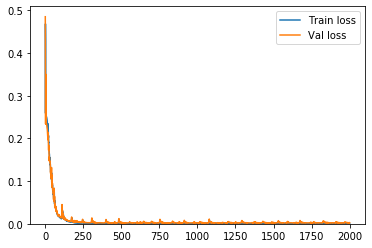

In [62]:
plot_loss_vs_epochs(train_losess, val_losses)

5. Briefly explain graph's results.

We can see that the test and the train are decreasing as we continue training the model, even after 2000 epochs.
We can assume that the data is simple and the model understands how the data built, so it can also continue to learn and make progress on the test set. At the begining the model is learning very much from the data (the loss decreasing significantly) and after the model learning ~220 epochs, the net understands how the data generated and the loss is very low, both on the train set and the test set.

Type your answer here:



6. How does your metric value differs between the training data and the test data and why?


In [86]:
print('Train MSE: {}'.format(infer(net, training_generator, nn.MSELoss)))
print('Test MSE: {}'.format(infer(net, test_generator, nn.MSELoss)))

Train MSE: 0.0002
Test MSE: 0.0021


**Type your answer here:**<br>
The model performed on the train set better than test set. We can see that the train MSE is smaller as we expected. Part of the function is a simple deterministic with little noise (random * 0.1), so the model is learning good. Also, there is a component which is random, so the loss cannot be zero, however, it's very close.